# START

In [1]:
import datetime
import glob
import os
import numpy as np
import pandas as pd
import time

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from utils import set_seed, load_features_from_csv


from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,recall_score,precision_score,accuracy_score, log_loss

from scipy.stats import loguniform, uniform, randint, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests


In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [4]:
pd.set_option('display.precision', 3)

# Define Utility Functions

In [5]:
segment_order = ['CD45+', 'PanCK+']
geneset_order = ['Panel','HVG', 'SVG']
SCORE_STAT = 'neg_mean_squared_error'
seed=77

In [6]:
def plot_top_gene_preds(y_test, y_pred, genenames, output_path):
    num_genes = len(genenames)
    fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=False, sharey=False)
    axs = axs.flatten()

    for i, genename in enumerate(genenames):
   
        sns.scatterplot(x=y_test[genename], y=y_pred[genename], ax=axs[i])
        plt.xlabel(f"True Expression ({genename})")
        plt.ylabel("Predicted Expression")
        plt.title(f"Actual vs Predicted for {genename}")
        plt.plot([y_test[:, i].min(), y_test[:, i].max()],
                [y_test[:, i].min(), y_test[:, i].max()], 'r--')
        plt.grid(True)

1: Cancer Bioinformatics, School of Cancer & Pharmaceutical Sciences, Faculty of Life Sciences and Medicine, King's College London, London, United Kingdom 

In [7]:
def plot_and_save_gene_preds(y_test, y_pred, genenames, geneset, output_path):

    figpath = os.path.join(output_path,'figs')
    os.makedirs(figpath,exist_ok=True)
    
    for i, genename in enumerate(genenames):
        curr_date=str(datetime.date.today())
        curr_time=datetime.datetime.now().strftime('%H%M')
        filename=f'summaryplot-{genename}-{geneset}-{curr_date}_{curr_time}.png'

        # Optional: Plot one gene as example (e.g., gene 0)
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_test[:, i], y=y_pred[:, i])
        plt.xlabel(f"True Expression ({genename})")
        plt.ylabel("Predicted Expression")
        plt.title(f"Actual vs Predicted for {geneset} {genename}")
        plt.plot([y_test[:, i].min(), y_test[:, i].max()],
                [y_test[:, i].min(), y_test[:, i].max()], 'r--')
        plt.grid(True)
        plotname = f"scatter_{geneset}_{genename}.png".replace(" ", "_")
        #print(f"saving plot to {output_path}/{filename}")
        #print("os.path.exists:", os.path.exists(os.path.join(output_path, filename)))
        #print("Can write to output_path:", os.access(output_path, os.W_OK))

        try:
            plt.savefig(os.path.join(figpath,filename), dpi=300, bbox_inches='tight')
            #print(f"Saved plot to: {figpath}")
            
        except Exception as e:
            print(f"❌ Failed to save plot ")
        #plt.show()
        plt.close()

In [8]:
ci_highs = [5,5,5,5]
ci_lows = [3,3,1,1]

widths = [high - low for high, low in zip(ci_highs, ci_lows)]
widths

[2, 2, 4, 4]

In [9]:
def get_regression_scores(y_test, y_pred, geneset='HVG',segment='CD45+',feat_extr='uni', model='SVM',output_path=''):
    gene_names = list(y_test.columns)
    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)

    #for i, gene in enumerate(gene_names):
    #    print(f"SCORING {gene}",flush=True)

    # Compute per-gene (column) metrics
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    # Compute std of true expression (for nRMSE)
    std = np.std(y_test, axis=0, ddof=1)
    nrmse = rmse / std
    
    # Correlations per gene
    pearson_results = [pearsonr(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    spearman_results = [spearmanr(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    pearson_corrs, pearson_pvals = zip(*pearson_results)
    spearman_corrs, spearman_pvals = zip(*spearman_results)
    pearson_ci_highs = [res.confidence_interval().high for res in pearson_results]
    pearson_ci_lows = [res.confidence_interval().low for res in pearson_results]
    pearson_ci_widths = [high - low for high, low in zip(pearson_ci_highs, pearson_ci_lows)]
    
    # FDR correction
    _, pearson_qvals, _, _ = multipletests(pearson_pvals, method='fdr_bh')
    _, spearman_qvals, _, _ = multipletests(spearman_pvals, method='fdr_bh')

    # Per-gene DataFrame
    n_genes = y_test.shape[1]
    per_gene_df = pd.DataFrame({
        'Gene': gene_names, #[f'Gene_{i}' for i in range(n_genes)],
        'MSE': mse,
        'RMSE': rmse,
        'nRMSE': nrmse,
        'MAE': mae,
        'R2': r2,
        'Pearson Corr': pearson_corrs,
        'PearsonPVals': pearson_pvals,
        'PearsonQVals': pearson_qvals,
        'PearsonCI_low': pearson_ci_lows,
        'PearsonCI_high': pearson_ci_highs,
        'Spearman Corr': spearman_corrs,
        'SpearmanPVals': spearman_pvals,
        'SpearmanQVals': spearman_qvals,
    })
    per_gene_df.insert(0, 'GeneSet', geneset)
    per_gene_df.insert(1, 'Segment', segment)
    per_gene_df.insert(2,'Feature_Extractor',feat_extr)
    per_gene_df.insert(3,'Model',model)

    # Summary row
    # Aggregate (mean)
    mean_metrics = {
        'MSE': mse.mean(),
        'RMSE': rmse.mean(),
        'nRMSE': np.nanmean(nrmse),
        'MAE': mae.mean(),
        'R2': r2.mean(),
        'Pearson Corr': np.nanmean(pearson_corrs),
        'PearsonPVals': np.median(pearson_pvals),
        'PearsonQVals': np.median(pearson_qvals),
        'PearsonCIWidth': np.median(pearson_ci_widths),
        'Spearman Corr': np.nanmean(spearman_corrs),
        'SpearmanPVals': np.median(spearman_pvals),
        'SpearmanQVals': np.median(spearman_qvals),

    }

    summary_df = pd.DataFrame([mean_metrics])
    summary_df.insert(0, 'GeneSet', geneset)
    summary_df.insert(1, 'Segment', segment)
    summary_df.insert(2,'Feature_Extractor',feat_extr)
    summary_df.insert(3,'Model',model)



    plot_and_save_gene_preds(y_test, y_pred, gene_names,geneset,output_path)

    return summary_df, per_gene_df




In [10]:
model_lookup = {
    'SVM': SVR,
    'elasticnet': lambda: ElasticNet(random_state=seed)
}

In [11]:
def train_final_regressor(model, X_train, y_train, gene_names, gene_params):
    print(f"Training {len(gene_names)} models")
    tuned_models = []

    if model not in model_lookup:
        print(f"Unrecognized model type: {model}")
        return

    for i in range(y_train.shape[1]):

        #print(f"{i} - Training model for gene {gene_names[i]}")
        params = eval(gene_params[i])

        base_model = model_lookup[model]()
        model_instance  = base_model.set_params(**params)
        model_instance.fit(X_train, y_train.iloc[:, i])
        tuned_models.append(model_instance)
        
    return tuned_models

In [12]:

def evaluate_final_models(models, X_test, y_test, 
                          geneset='HVG',segment='CD45+',feat_extr='uni',model='SVM',
                          output_path='',save=True):
    # Predict each gene separately
    y_pred = np.column_stack([model.predict(X_test) for model in models])


    # Compute metrics
    summary_scores, per_gene_scores = get_regression_scores(
        y_test,
        y_pred,
        geneset,segment,feat_extr,model,
        output_path=output_path
    )


    if save:
        # Save per-gene metrics
        print(f"saving to: {output_path}")
        per_gene_scores.to_csv(os.path.join(output_path,f"FINAL_per_gene_scores-{geneset}-{segment}.csv"), index=False)
        #summary_scores.to_csv(os.path.join(output_path,f"FINAL_summary_scores-{geneset}-{segment}.csv"), index=False)

    return summary_scores, per_gene_scores, y_pred

# Data Load

In [13]:
root_path = 'E:/01-data/LEAP/output/summaries'

In [14]:
input_path='E:/01-data/LEAP/features'
output_path='E:/01-data/LEAP/output/final_run'
truth_path='E:/01-data/LEAP/truthlabels'


In [15]:
curr_date=str(datetime.date.today())
curr_time=datetime.datetime.now().strftime('%H%M')
name=f"retrain_final_models_{curr_date}_{curr_time}"
print(name)

retrain_final_models_2025-07-29_1306


In [16]:
#set up paths for models, training curves and predictions
save_path = os.path.join(output_path,name)
os.makedirs(save_path,exist_ok=True)

print(f"ip: {input_path}")
print(f"op: {save_path}")


ip: E:/01-data/LEAP/features
op: E:/01-data/LEAP/output/final_run\retrain_final_models_2025-07-29_1306


Read in params for each gene

In [17]:
all_gene_scores = pd.read_csv(os.path.join(root_path,'allgenescores.csv'))
all_gene_scores = all_gene_scores.drop(columns=['index'])
all_gene_scores.shape

(2844, 12)

this will need to be per geneset and per segment

In [18]:
def load_data(geneset, feat_extr, segment, test=False):
    if test:
        suffix='_TEST'
    else:
        suffix=''
    print(geneset)
    print(feat_extr)
    feat_file= f'{feat_extr}-{segment}_features.csv'
    print(feat_file)
    truth_file=f'{geneset.lower()}_{segment[:-1].lower()}_raw_v3{suffix}.csv'
    print(truth_file)

    # 1. read in outcomes
    outcome_df = pd.read_csv(os.path.join(truth_path,truth_file))
    outcome_df = outcome_df.set_index('ROI_ID')
    ## doing this to check later if the first gene is NA
    sig_name = outcome_df.columns[0]
    
    print(f"feature file: {feat_file}")
    image_names, feature_matrix = load_features_from_csv(os.path.join(input_path,feat_file))

    """if i'm reading features from a file then have to get metadata from image names"""

    patch_metadata = pd.DataFrame([x.replace('.png','').split('_') for x in image_names],columns=['name', 'LEAP_ID', 'Segment','ROI_num', 'x', 'y'])
    patch_metadata = patch_metadata.set_index('name')
    patch_metadata = patch_metadata.filter(items=['LEAP_ID'])
    # remove patches that we don't have both features and outcomes

    merged_df = patch_metadata.join(outcome_df, how='left')

    mask = ~merged_df[sig_name].isna()
    feature_matrix_clean = feature_matrix[mask.values]
    merged_df = merged_df.dropna(subset=[sig_name])

    return feature_matrix_clean, merged_df


# Train and Evaluate the final models

read in the top models that we need to use

In [19]:
best_per_segment = pd.read_csv(os.path.join(root_path,'best_model_per_segment_goodpredictors.csv'))

In [20]:
best_per_segment

,Segment,Feature_Extractor,ML_Model,nRMSE,Pearson Corr,Spearman Corr
0,CD45+,virchow,SVM,0.735,0.600,0.594
1,PanCK+,uni,SVM,0.896,0.566,0.569


In [21]:
seg_test_scores_list = []
seg_test_gene_scores_list = []
final_models = {}
y_test_dict = {}
y_pred_dict = {}

for idx, row in best_per_segment.iterrows():
    segment = row['Segment']
    feat_extr = row['Feature_Extractor']
    model = row['ML_Model']


    for geneset in geneset_order:

        print(f"****** {geneset} | {segment} | {feat_extr} | {model} ******")
            
        X_train, y_train = load_data(geneset, feat_extr, segment)
        print("Feature Matrix Shape:", X_train.shape)
        print("Outcome Shape:", len(y_train))  # Should match the number of images

        ## Get the hyperparameters selected during CV 
        cond = all_gene_scores['GeneSet']==geneset
        cond = cond & (all_gene_scores['Segment']==segment)
        cond = cond & (all_gene_scores['Feature_Extractor']==feat_extr)
        cond = cond & (all_gene_scores['ML_Model']==model)
        params_subset = all_gene_scores.loc[cond,['Gene','Params']]
        print(params_subset)


        if not all(params_subset['Gene'].values == y_train.drop(columns='LEAP_ID').columns):
            print("Sorting params")
            params_subset = (
                params_subset.set_index('Gene')
                .reindex(y_train.drop(columns='LEAP_ID').columns)
                .reset_index()
                .rename(columns={'index': 'Gene'})  # in case the name gets lost
            )
            #raise ValueError("params_subset['Gene'] is not in the same order as y_train.columns")
        else:
            print("OK")


            
        ######### TRAIN MODELS ###########################################

            

        y_train = y_train.drop(columns=['LEAP_ID'])
        trained_models = train_final_regressor(model, X_train, y_train, list(params_subset['Gene']), list(params_subset['Params']))


        ###################################################################################
        ######### EVALUATE ON HOLD OUT TEST SET ###########################################
        ###################################################################################

        #### LOAD DATA ####################################################################
        X_test, y_test = load_data(geneset, feat_extr, segment, test=True)
        print("Feature Matrix Shape:", X_test.shape)
        print("Outcome Shape:", len(y_test))  # Should match the number of images

        y_test_dict[(segment,geneset)] = y_test

        #### EVALUATE ######################################################################
        y_test = y_test.drop(columns=['LEAP_ID'])
        summary_scores, per_gene_scores, y_pred = evaluate_final_models(trained_models, X_test, y_test,
                                                                    geneset, segment, feat_extr, model,
                                                                    output_path=save_path)
        
        seg_test_scores_list.append(summary_scores)
        seg_test_gene_scores_list.append(per_gene_scores)
        y_pred_dict[(segment,geneset)] = y_pred
        final_models[(segment,geneset)] = {g:m for g, m in zip(list(y_test.columns), trained_models)}


****** Panel | CD45+ | virchow | SVM ******
Panel
virchow
virchow-CD45+_features.csv
panel_cd45_raw_v3.csv
feature file: virchow-CD45+_features.csv
Feature Matrix Shape: (1287, 2560)
Outcome Shape: 1287
        Gene                                             Params
2738   CD274  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2739   CXCL9  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2740    IFNG  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2741    BCL2  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2742    CD3D  {'C': 0.1, 'coef0': 1, 'degree': 3, 'epsilon':...
2743    CD8A  {'C': 1, 'coef0': 1, 'degree': 2, 'epsilon': 0...
2744     CD4  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2745   FOXP3  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2746    CD68  {'C': 1, 'coef0': 0.05, 'degree': 2, 'epsilon'...
2747   CD163  {'C': 0.1, 'coef0': 1, 'degree': 2, 'epsilon':...
2748    IDO1  {'C': 1, 'coef0': 0.05, 'degree': 2, 'epsilon'...
2749    LAG3  {'C': 0.1, 'coe

In [22]:
X_train

array([[-0.11425091,  0.6825682 ,  0.80917054, ...,  0.6797202 ,
         0.83365864, -0.10624631],
       [ 1.0025855 ,  2.249329  ,  0.5770767 , ...,  0.02032661,
         1.9946398 ,  0.35411838],
       [ 1.3706793 ,  2.3013246 ,  0.8079381 , ..., -1.0687623 ,
         1.4261954 ,  1.0726702 ],
       ...,
       [-0.6816126 ,  0.45347866,  0.5740903 , ...,  0.9537449 ,
         2.2222207 ,  0.24529225],
       [ 0.0965879 ,  0.29460037,  0.7242418 , ...,  0.37621635,
         1.132052  ,  2.317469  ],
       [-0.38293484, -0.70865476, -0.04739136, ..., -0.05296354,
         1.6534406 ,  1.5202007 ]])

In [23]:
cd45_rois = y_test_dict[('CD45+', 'Panel')][['LEAP_ID']]
panck_rois = y_test_dict[('PanCK+', 'Panel')][['LEAP_ID']]

In [24]:
cd45_rois=cd45_rois.drop('DSP-1001660018904-B-A06.dcc')

In [25]:
cd45_rois

,LEAP_ID
name,
DSP-1001660013512-B-B06.dcc,LEAP032
DSP-1001660013512-B-B08.dcc,LEAP032
DSP-1001660013512-B-C06.dcc,LEAP032
DSP-1001660013512-B-A06.dcc,LEAP033
DSP-1001660013512-B-A10.dcc,LEAP033
...,...
DSP-1001660020485-C-E02.dcc,LEAP121
DSP-1001660020485-C-E04.dcc,LEAP121
DSP-1001660020485-C-E08.dcc,LEAP121


In [26]:
final_models

{('CD45+',
  'Panel'): {'CD274': SVR(C=0.1, coef0=1, degree=2, epsilon=0.01, kernel='poly'), 'CXCL9': SVR(C=0.1, coef0=1, degree=2, epsilon=0.01, gamma=0.001, kernel='poly'), 'IFNG': SVR(C=0.1, coef0=1, degree=2, epsilon=0.2, kernel='poly'), 'BCL2': SVR(C=0.1, coef0=1, degree=2, epsilon=0.05, kernel='poly'), 'CD3D': SVR(C=0.1, coef0=1, epsilon=0.2, kernel='poly'), 'CD8A': SVR(C=1, coef0=1, degree=2, epsilon=0.01, kernel='poly'), 'CD4': SVR(C=0.1, coef0=1, degree=2, epsilon=0.2, gamma=0.001, kernel='poly'), 'FOXP3': SVR(C=0.1, coef0=1, degree=2, epsilon=0.2, kernel='poly'), 'CD68': SVR(C=1, coef0=0.05, degree=2, epsilon=0.01, kernel='poly'), 'CD163': SVR(C=0.1, coef0=1, degree=2, epsilon=0.2, kernel='poly'), 'IDO1': SVR(C=1, coef0=0.05, degree=2, epsilon=0.01, kernel='poly'), 'LAG3': SVR(C=0.1, coef0=1, degree=2, kernel='poly'), 'STAT1': SVR(C=0.1, coef0=1, gamma=0.001, kernel='poly'), 'S100A9': SVR(C=1, epsilon=0.2)},
 ('CD45+',
  'HVG'): {'KRT14': SVR(C=0.1, coef0=1, degree=2, epsilon

In [27]:
seg_test_scores = pd.concat(seg_test_scores_list, ignore_index=True, sort=False)
seg_test_gene_scores = pd.concat(seg_test_gene_scores_list, ignore_index=True, sort=False)
seg_test_scores.drop(columns=['MSE','RMSE','MAE','R2'])

,GeneSet,Segment,Feature_Extractor,Model,nRMSE,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCIWidth,Spearman Corr,SpearmanPVals,SpearmanQVals
0,Panel,CD45+,virchow,SVM,0.658,0.769,7.617e-28,1.417e-27,0.137,0.754,7.970e-27,1.466e-26
1,HVG,CD45+,virchow,SVM,0.776,0.658,4.913e-20,9.582e-20,0.181,0.650,4.297e-19,8.340e-19
2,SVG,CD45+,virchow,SVM,0.684,0.747,5.960e-26,1.169e-25,0.147,0.723,4.146e-23,8.123e-23
3,Panel,PanCK+,uni,SVM,0.927,0.499,8.696e-14,1.667e-13,0.219,0.505,4.684e-14,8.977e-14
4,HVG,PanCK+,uni,SVM,0.960,0.421,1.347e-08,2.621e-08,0.252,0.413,4.077e-09,7.892e-09
5,SVG,PanCK+,uni,SVM,0.932,0.456,3.157e-10,6.132e-10,0.241,0.463,8.678e-11,1.690e-10


In [28]:
# Step 1: Transpose and set column names as row index
df_panel = y_test_dict[('CD45+', 'Panel')].drop(columns='LEAP_ID').T.rename_axis('Gene').reset_index()
df_hvg = y_test_dict[('CD45+', 'HVG')].drop(columns=['LEAP_ID']).T.rename_axis('Gene').reset_index()
df_svg = y_test_dict[('CD45+', 'SVG')].drop(columns=['LEAP_ID']).T.rename_axis('Gene').reset_index()
# Step 2: Merge using the row index
y_test_cd45 = pd.concat([df_panel,df_hvg,df_svg])
y_test_cd45

name,Gene,DSP-1001660013512-B-B06.dcc,DSP-1001660013512-B-B08.dcc,DSP-1001660013512-B-C06.dcc,DSP-1001660013512-B-A06.dcc,DSP-1001660013512-B-A10.dcc,DSP-1001660013512-B-A12.dcc,DSP-1001660014498-F-A05.dcc,DSP-1001660014498-F-A08.dcc,DSP-1001660014498-F-A11.dcc,...,DSP-1001660020485-C-C10.dcc,DSP-1001660020485-C-C12.dcc,DSP-1001660020485-C-D02.dcc,DSP-1001660020485-C-D06.dcc,DSP-1001660020485-C-D10.dcc,DSP-1001660020485-C-E02.dcc,DSP-1001660020485-C-E04.dcc,DSP-1001660020485-C-E08.dcc,DSP-1001660020485-C-E10.dcc,DSP-1001660020485-C-E11.dcc
0,CD274,0.693,0.693,0.693,0.693,0.693,0.693,2.833,2.565,1.386,...,1.609,0.693,0.693,0.693,2.079,0.693,1.099,0.693,3.401,2.398
1,CXCL9,0.693,0.693,1.386,0.693,1.099,1.099,3.850,3.638,1.792,...,2.303,0.693,0.693,0.693,3.135,1.099,0.693,1.792,3.332,3.892
2,IFNG,1.099,1.099,1.099,0.693,0.693,1.099,2.197,2.833,2.485,...,0.693,0.693,1.386,0.693,0.693,0.693,0.693,1.099,2.708,2.197
3,BCL2,1.609,1.099,1.099,0.693,1.386,0.693,2.944,2.996,2.079,...,2.303,1.099,1.792,0.693,2.398,0.693,1.099,1.099,4.595,3.091
4,CD3D,0.693,1.609,0.693,0.693,0.693,0.693,2.833,2.639,1.792,...,2.565,0.693,1.792,0.693,2.773,0.693,0.693,0.693,4.443,2.944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,REPS2,1.099,0.693,0.693,0.693,1.099,1.609,2.398,2.944,2.197,...,0.693,1.099,1.386,0.693,1.946,0.693,0.693,0.693,3.045,2.197
46,ST6GALNAC3,0.693,0.693,0.693,0.693,1.099,0.693,2.565,2.944,1.099,...,1.609,0.693,0.693,0.693,1.792,0.693,1.099,1.099,3.219,1.609
47,HLA-E,2.565,3.135,2.773,2.833,3.761,3.045,4.344,4.682,2.773,...,4.419,2.565,3.689,2.833,5.011,2.890,3.638,2.565,6.293,5.541
48,APOE,1.099,0.693,1.099,2.485,1.609,0.693,3.466,4.277,2.565,...,2.833,2.639,2.708,1.386,3.807,1.609,3.466,1.609,3.829,4.317


In [29]:

df_panel = pd.DataFrame(y_pred_dict[('CD45+', 'Panel')].T)
df_hvg = pd.DataFrame(y_pred_dict[('CD45+', 'HVG')].T)
df_svg = pd.DataFrame(y_pred_dict[('CD45+', 'SVG')].T)
y_pred_cd45 = pd.concat([df_panel,df_hvg,df_svg])
y_pred_cd45.insert(0, 'Gene', y_test_cd45['Gene'])
y_pred_cd45.columns = y_test_cd45.columns
y_pred_cd45 = y_pred_cd45.set_index('Gene')
y_test_cd45 = y_test_cd45.set_index('Gene')
y_pred_cd45.shape

(114, 130)

In [30]:
y_pred_cd45

name,DSP-1001660013512-B-B06.dcc,DSP-1001660013512-B-B08.dcc,DSP-1001660013512-B-C06.dcc,DSP-1001660013512-B-A06.dcc,DSP-1001660013512-B-A10.dcc,DSP-1001660013512-B-A12.dcc,DSP-1001660014498-F-A05.dcc,DSP-1001660014498-F-A08.dcc,DSP-1001660014498-F-A11.dcc,DSP-1001660014498-F-B02.dcc,...,DSP-1001660020485-C-C10.dcc,DSP-1001660020485-C-C12.dcc,DSP-1001660020485-C-D02.dcc,DSP-1001660020485-C-D06.dcc,DSP-1001660020485-C-D10.dcc,DSP-1001660020485-C-E02.dcc,DSP-1001660020485-C-E04.dcc,DSP-1001660020485-C-E08.dcc,DSP-1001660020485-C-E10.dcc,DSP-1001660020485-C-E11.dcc
Gene,,,,,,,,,,,,,,,,,,,,,
CD274,0.688,1.042,0.941,0.882,0.975,1.242,1.940,2.567,1.886,2.057,...,1.641,1.882,1.365,1.294,2.095,1.858,1.800,1.429,2.578,2.252
CXCL9,1.075,1.638,1.464,1.120,1.142,1.280,3.667,4.888,4.145,3.777,...,2.836,3.704,2.422,2.241,3.967,3.496,3.006,2.061,4.428,4.052
IFNG,0.724,0.990,0.901,0.981,1.057,1.239,1.772,2.382,2.115,2.086,...,1.531,1.628,1.518,1.431,1.820,1.780,1.708,1.208,2.368,1.885
BCL2,0.874,1.301,1.282,1.150,1.180,1.542,2.062,2.806,2.309,2.251,...,2.036,2.081,1.620,1.630,2.383,2.176,2.097,1.597,3.149,2.521
CD3D,0.954,1.268,1.025,0.521,0.662,0.982,2.563,3.172,2.528,2.339,...,2.171,2.240,1.706,1.587,2.723,2.255,2.129,1.397,3.523,2.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REPS2,0.791,1.222,0.896,0.684,0.948,1.071,1.855,2.444,2.142,2.056,...,1.642,1.639,1.100,1.134,1.997,1.635,1.680,1.273,2.687,2.214
ST6GALNAC3,0.811,1.294,1.178,0.612,1.058,1.084,1.819,2.145,1.829,1.893,...,1.736,1.895,1.140,1.214,2.297,1.604,1.993,1.352,3.026,2.523
HLA-E,1.987,2.764,2.386,2.075,1.943,3.060,5.141,5.895,4.865,4.551,...,3.982,5.164,3.467,3.924,5.884,4.675,4.641,3.442,5.803,6.067


In [31]:
y_pred_cd45 = y_pred_cd45.drop(columns=['DSP-1001660018904-B-A06.dcc'])
y_test_cd45 = y_test_cd45.drop(columns=['DSP-1001660018904-B-A06.dcc'])

In [32]:
# Step 1: Transpose and set column names as row index
df_panel = y_test_dict[('PanCK+', 'Panel')].drop(columns='LEAP_ID').T.rename_axis('Gene').reset_index()
df_hvg = y_test_dict[('PanCK+', 'HVG')].drop(columns=['LEAP_ID']).T.rename_axis('Gene').reset_index()
df_svg = y_test_dict[('PanCK+', 'SVG')].drop(columns=['LEAP_ID']).T.rename_axis('Gene').reset_index()
# Step 2: Merge using the row index
y_test_panck = pd.concat([df_panel,df_hvg,df_svg])
y_test_panck.shape

(123, 164)

In [33]:

df_panel = pd.DataFrame(y_pred_dict[('PanCK+', 'Panel')].T)
df_hvg = pd.DataFrame(y_pred_dict[('PanCK+', 'HVG')].T)
df_svg = pd.DataFrame(y_pred_dict[('PanCK+', 'SVG')].T)
y_pred_panck = pd.concat([df_panel,df_hvg,df_svg])
y_pred_panck.insert(0, 'Gene', y_test_panck['Gene'])
y_pred_panck.columns = y_test_panck.columns
y_pred_panck = y_pred_panck.set_index('Gene')
y_test_panck = y_test_panck.set_index('Gene')
y_pred_panck.shape

(123, 163)

# Analyse Results

How many genes exceed the threshold for signif

significant_count = np.sum(np.array(fdr_adjusted_pvals) < 0.05)
proportion_significant = significant_count / len(fdr_adjusted_pvals)

“Model selection was based on nRMSE across the validation set (mean R² > 0.2). Final model performance was evaluated on a held-out test set not used in model selection. Correlations and p-values reported below reflect test-set-only results.”

Proportion of genes with CI excluding 0 (i.e., significantly non-zero correlation)
“Across 500 genes with R² > 0.2, Pearson ρ 95% CIs ranged from (0.12–0.35) to (0.81–0.91), with a median width of 0.18.”
e.g., immune markers, proliferation genes, or your top 10 predictions

Present: ρ ± CI or ρ (95% CI: low–high)

 if qval <= 0.001:
        sig = "***"
    elif qval <= 0.01:
        sig = "**"
    elif qval <= 0.05:

## Proportion of significant genes 

In [34]:
signif_thresh = 0.001

In [35]:
seg_test_gene_scores

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
0,Panel,CD45+,virchow,SVM,CD274,0.463,0.680,0.619,0.571,0.614,0.811,1.585e-31,7.398e-31,0.742,0.862,0.785,2.060e-28,7.209e-28
1,Panel,CD45+,virchow,SVM,CXCL9,1.080,1.039,0.635,0.765,0.594,0.781,6.724e-28,1.345e-27,0.703,0.840,0.774,3.358e-27,7.835e-27
2,Panel,CD45+,virchow,SVM,IFNG,0.382,0.618,0.655,0.491,0.568,0.780,8.510e-28,1.489e-27,0.702,0.839,0.728,9.651e-23,1.351e-22
3,Panel,CD45+,virchow,SVM,BCL2,0.485,0.697,0.586,0.577,0.654,0.841,5.598e-36,7.837e-35,0.782,0.885,0.805,8.568e-31,8.449e-30
4,Panel,CD45+,virchow,SVM,CD3D,0.549,0.741,0.624,0.548,0.607,0.798,5.588e-30,1.565e-29,0.726,0.853,0.800,3.737e-30,1.744e-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,SVG,PanCK+,uni,SVM,C11orf58,1.214,1.102,0.886,0.877,0.211,0.560,7.960e-15,4.975e-14,0.444,0.657,0.550,2.865e-14,1.102e-13
233,SVG,PanCK+,uni,SVM,NWD2,0.927,0.963,0.872,0.724,0.236,0.588,1.533e-16,1.533e-15,0.478,0.680,0.624,6.093e-19,1.016e-17
234,SVG,PanCK+,uni,SVM,BLNK,1.033,1.016,0.904,0.796,0.178,0.494,2.033e-11,5.083e-11,0.368,0.602,0.521,1.002e-12,2.783e-12
235,SVG,PanCK+,uni,SVM,ACACB,1.268,1.126,0.920,0.925,0.149,0.480,9.098e-11,1.898e-10,0.352,0.590,0.486,4.841e-11,1.009e-10


In [36]:
num_signif = seg_test_gene_scores[seg_test_gene_scores['PearsonQVals']<signif_thresh].shape[0]
num_signif / seg_test_gene_scores.shape[0]

0.9324894514767933

CD45+ only

In [37]:
cond = (seg_test_gene_scores['Segment']=='CD45+') & (seg_test_gene_scores['PearsonQVals']<signif_thresh)
num_signif = seg_test_gene_scores.loc[cond,:].shape[0]
num_signif / seg_test_gene_scores[seg_test_gene_scores['Segment']=='CD45+'].shape[0]

0.9736842105263158

PanCK+ onlyl

In [38]:
cond = (seg_test_gene_scores['Segment']=='PanCK+') & (seg_test_gene_scores['PearsonQVals']<signif_thresh)
num_signif = seg_test_gene_scores.loc[cond,:].shape[0]
num_signif / seg_test_gene_scores[seg_test_gene_scores['Segment']=='PanCK+'].shape[0]

0.8943089430894309

In [39]:
seg_test_gene_scores.loc[seg_test_gene_scores['Segment']=='CD45+',:].sort_values('PearsonQVals', ascending=False)

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
47,HVG,CD45+,virchow,SVM,MZT2B,3.686,1.920,1.165,1.552,-0.369,0.036,6.823e-01,6.823e-01,-0.137,0.207,0.038,6.679e-01,6.679e-01
30,HVG,CD45+,virchow,SVM,MGP,5.583,2.363,1.393,1.772,-0.955,0.143,1.040e-01,1.062e-01,-0.030,0.308,0.135,1.270e-01,1.296e-01
51,HVG,CD45+,virchow,SVM,FNTB,0.643,0.802,1.046,0.615,-0.103,0.238,6.441e-03,6.710e-03,0.068,0.394,0.286,9.544e-04,9.941e-04
55,HVG,CD45+,virchow,SVM,HLA-DQA1,2.597,1.611,1.004,1.403,-0.016,0.395,3.211e-06,3.416e-06,0.240,0.531,0.477,9.385e-09,1.020e-08
60,HVG,CD45+,virchow,SVM,SPP1,1.244,1.115,0.917,0.874,0.152,0.397,2.883e-06,3.134e-06,0.242,0.533,0.443,1.341e-07,1.427e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,SVG,CD45+,virchow,SVM,C7,0.473,0.688,0.580,0.542,0.661,0.851,1.515e-37,2.524e-36,0.795,0.892,0.785,2.200e-28,1.000e-27
72,SVG,CD45+,virchow,SVM,PRMT8,0.943,0.971,0.633,0.789,0.596,0.859,5.965e-39,1.491e-37,0.805,0.898,0.860,2.971e-39,1.485e-37
15,HVG,CD45+,virchow,SVM,FDCSP,0.672,0.820,0.515,0.599,0.732,0.865,4.506e-40,1.126e-38,0.814,0.902,0.842,4.525e-36,2.262e-34
62,HVG,CD45+,virchow,SVM,AREG,0.607,0.779,0.524,0.643,0.724,0.869,5.273e-41,2.637e-39,0.820,0.906,0.795,1.516e-29,2.527e-28


In [40]:
np.sum(np.array(seg_test_gene_scores.loc[seg_test_gene_scores['Segment']=='CD45+','PearsonQVals']) < 0.05)

112

In [41]:
seg_test_gene_scores.shape[0]

237

In [42]:
seg_test_gene_scores[seg_test_gene_scores['PearsonQVals'] > 0.05].shape[0]

6

In [43]:
geneset_good_models = seg_test_gene_scores[seg_test_gene_scores['R2']>0.2].sort_values(by='nRMSE')

In [44]:
seg_test_gene_scores[seg_test_gene_scores['GeneSet']=='HVG'].describe()

,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
count,100.000,100.000,100.000,100.000,100.000,100.000,1.000e+02,1.000e+02,100.000,100.000,100.000,1.000e+02,1.000e+02
mean,1.800,1.263,0.868,1.012,0.216,0.539,1.339e-02,1.349e-02,0.422,0.639,0.531,1.234e-02,1.244e-02
std,1.378,0.455,0.159,0.367,0.289,0.196,7.761e-02,7.767e-02,0.222,0.168,0.184,7.372e-02,7.378e-02
min,0.293,0.541,0.515,0.445,-0.955,0.036,5.273e-41,2.637e-39,-0.137,0.207,0.038,4.525e-36,2.262e-34
25%,0.828,0.910,0.763,0.740,0.054,0.397,5.885e-21,2.004e-20,0.246,0.523,0.415,5.170e-19,1.050e-18
50%,1.487,1.219,0.868,0.956,0.241,0.568,2.218e-14,9.546e-14,0.447,0.669,0.552,1.897e-13,6.679e-13
75%,2.195,1.482,0.970,1.217,0.414,0.694,4.519e-07,7.430e-07,0.596,0.774,0.681,5.227e-08,8.923e-08
max,8.042,2.836,1.393,2.215,0.732,0.869,6.823e-01,6.823e-01,0.820,0.906,0.842,6.679e-01,6.679e-01


In [45]:
seg_test_gene_scores.head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
0,Panel,CD45+,virchow,SVM,CD274,0.463,0.680,0.619,0.571,0.614,0.811,1.585e-31,7.398e-31,0.742,0.862,0.785,2.060e-28,7.209e-28
1,Panel,CD45+,virchow,SVM,CXCL9,1.080,1.039,0.635,0.765,0.594,0.781,6.724e-28,1.345e-27,0.703,0.840,0.774,3.358e-27,7.835e-27
2,Panel,CD45+,virchow,SVM,IFNG,0.382,0.618,0.655,0.491,0.568,0.780,8.510e-28,1.489e-27,0.702,0.839,0.728,9.651e-23,1.351e-22
3,Panel,CD45+,virchow,SVM,BCL2,0.485,0.697,0.586,0.577,0.654,0.841,5.598e-36,7.837e-35,0.782,0.885,0.805,8.568e-31,8.449e-30
4,Panel,CD45+,virchow,SVM,CD3D,0.549,0.741,0.624,0.548,0.607,0.798,5.588e-30,1.565e-29,0.726,0.853,0.800,3.737e-30,1.744e-29


# Figure 4

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

“The majority of genes were significantly predicted (p < 0.05), with 94–100% of genes showing significance across all Segment × GeneSet combinations.”

C:\Users\hooll\AppData\Local\Temp\ipykernel_35152\963200427.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Immune Regions (CD45⁺)", "Tumour Regions (PanCK⁺)"], fontsize=12)


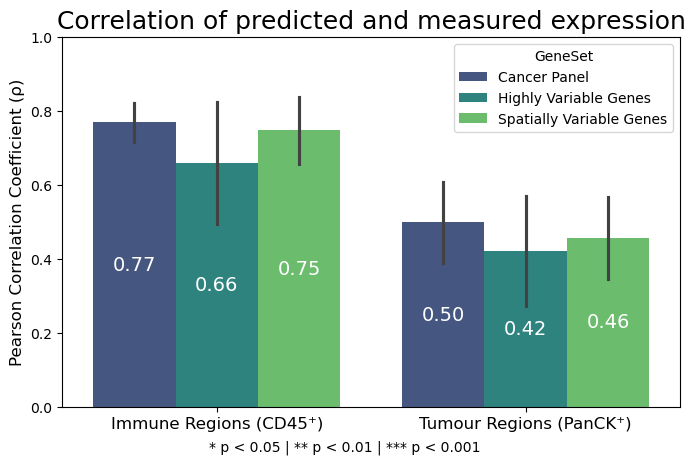

In [47]:


plt.figure(figsize=(7, 5))
ax = sns.barplot(
    data=seg_test_gene_scores,
    x='Segment',
    y='Pearson Corr',
    hue='GeneSet',
    order=segment_order,
    hue_order=geneset_order,
    palette='viridis',
    errorbar='sd'
)
# Add value labels automatically
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='center', fontsize=14, color='white')

# Replace x-tick labels
ax.set_xticklabels(["Immune Regions (CD45⁺)", "Tumour Regions (PanCK⁺)"], fontsize=12)

# Axis labels and title
ax.set_ylabel("Pearson Correlation Coefficient (ρ)", fontsize=12)
ax.set_xlabel("")
ax.set_ylim(0.0, 1.0)
plt.title("Correlation between predicted and measured expression in hold-out test set")

# Legend formatting
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Cancer Panel', 'Highly Variable Genes', 'Spatially Variable Genes']
ax.legend(handles, new_labels, title="GeneSet", loc='upper right', frameon=True)


# for i, (val, qval) in enumerate(zip(
#     seg_test_gene_scores["Pearson Corr"],
#     seg_test_gene_scores["PearsonQVals"]
# )):
#     if qval <= 0.001:
#         sig = "***"
#     elif qval <= 0.01:
#         sig = "**"
#     elif qval <= 0.05:
#         sig = "*"
#     else:
#         sig = ""
#     xpos = val + 0.01  
#     ax.text(xpos, i, sig, va='center', fontsize=10, fontweight='bold')
#
plt.tight_layout(rect=[0, 0.01, 1, 0.9])
plt.title("Correlation of predicted and measured expression", fontsize=18)

plt.figtext(0.5, 0.0, '* p < 0.05 | ** p < 0.01 | *** p < 0.001', ha='center', fontsize=10)
plt.savefig("pcc_correlation_plot.pdf", format='pdf', bbox_inches='tight')  
plt.show()

# Figure 5 Correlation Distribution histograms

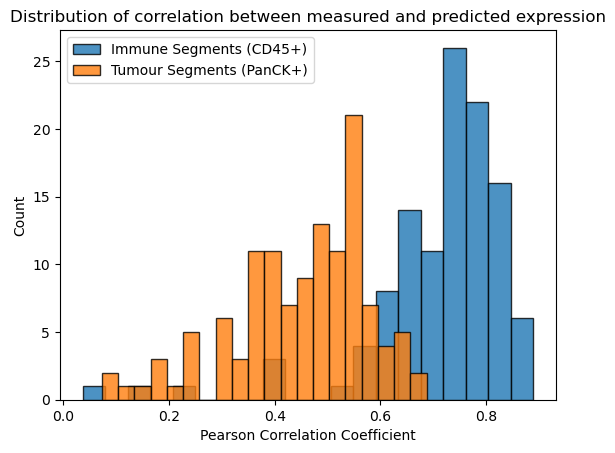

In [48]:
plt.hist(seg_test_gene_scores.loc[seg_test_gene_scores['Segment']=='CD45+','Pearson Corr'], 
         bins=20,   edgecolor='black', alpha=0.8, label='Immune Segments (CD45+)')


plt.hist(seg_test_gene_scores.loc[seg_test_gene_scores['Segment']=='PanCK+','Pearson Corr'], 
         bins=20, edgecolor='black', alpha=0.8, label='Tumour Segments (PanCK+)')
plt.title("Distribution of correlation between measured and predicted expression")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Count")
plt.legend()

plt.show()

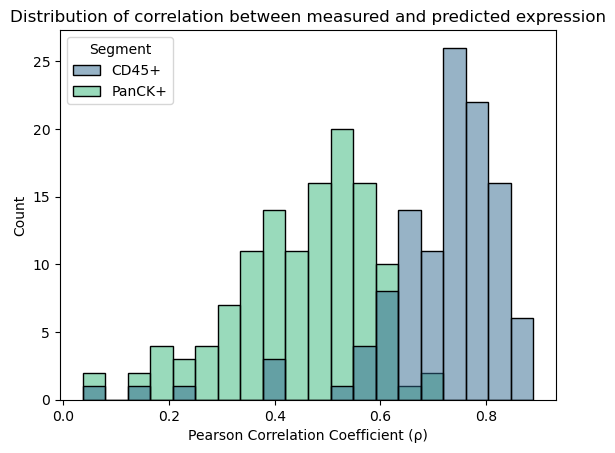

In [49]:
sns.histplot(
    data=seg_test_gene_scores,
    x='Pearson Corr',
    hue='Segment',
    bins=20,
    element='bars',  # or "bars"
    common_norm=False,  # don’t normalize across groups
    palette='viridis',
    edgecolor='black'
)
plt.title("Distribution of correlation between measured and predicted expression")
plt.xlabel("Pearson Correlation Coefficient (ρ)")
plt.ylabel("Count")


plt.show()

# Combined 4 and 5

In [50]:
SUPTITLESIZE=18
TITLESIZE=16
LABELSIZE=14
NOTESIZE=10

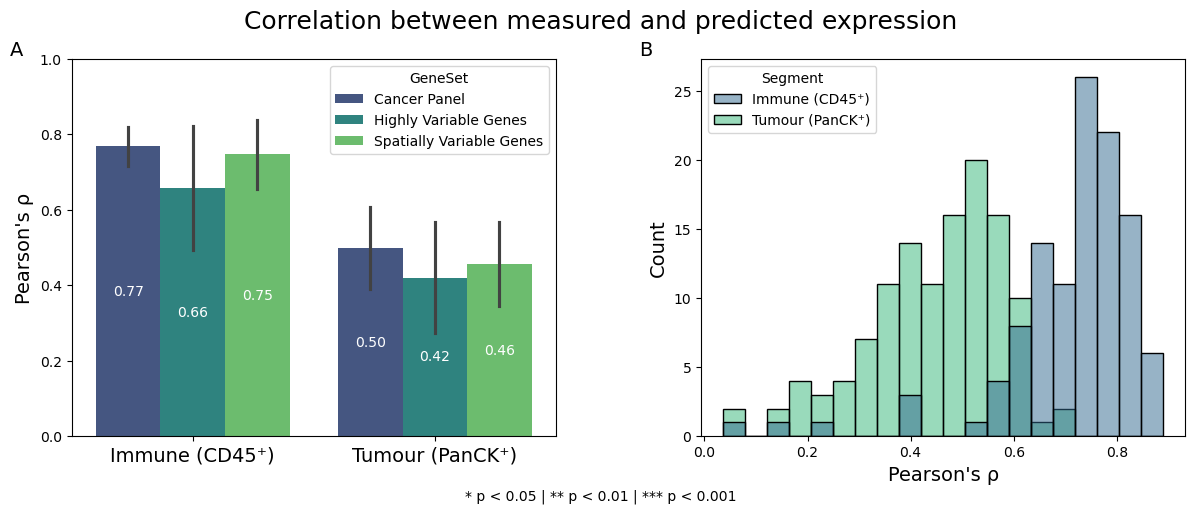

In [ ]:

fig, axes = plt.subplots( 1, 2, figsize=(12,5))

### A

sns.barplot(
    data=seg_test_gene_scores,
    x='Segment',
    y='Pearson Corr',
    hue='GeneSet',
    order=segment_order,
    hue_order=geneset_order,
    palette='viridis',
    errorbar='sd',
    ax=axes[0]
)
# Add value labels automatically
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", label_type='center',  color='white')

# Replace x-tick labels
axes[0].set_xticks(range(len(segment_order)))  # Optional but useful

axes[0].set_xticklabels(["Immune (CD45⁺)", "Tumour (PanCK⁺)"], fontsize=LABELSIZE)

# Axis labels and title
axes[0].set_ylabel("Pearson's ρ", fontsize=LABELSIZE) #, fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylim(0.0, 1.0)
#axes[0].set_title("Correlation between predicted and measured expression in hold-out test set")

# Legend formatting
handles, labels = axes[0].get_legend_handles_labels()
new_labels = ['Cancer Panel', 'Highly Variable Genes', 'Spatially Variable Genes']
axes[0].legend(handles, new_labels, title="GeneSet", loc='upper right', frameon=True)


### B
sns.histplot(
    data=seg_test_gene_scores,
    x='Pearson Corr',
    hue='Segment',
    bins=20,
    element='bars',  # or "bars"
    common_norm=False,  # don’t normalize across groups
    palette='viridis',
    edgecolor='black',
    ax=axes[1]
)
#axes[1].set_title("Distribution of correlation between measured and predicted expression")
axes[1].set_xlabel("Pearson's ρ", fontsize=LABELSIZE)
axes[1].set_ylabel("Count", fontsize=LABELSIZE)

## cant use get_legend_handles... for some reason
legend = axes[1].get_legend()
if legend:
    labels = ['Immune (CD45⁺)', 'Tumour (PanCK⁺)']
    for text, new_label in zip(legend.get_texts(), labels):
        text.set_text(new_label)

fig.suptitle('Correlation between measured and predicted expression', ha='center', fontsize=SUPTITLESIZE)
plt.figtext(0.5, 0.0, '* p < 0.05 | ** p < 0.01 | *** p < 0.001', ha='center', fontsize=NOTESIZE)

### Prepare for paper
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes,
             fontsize=14,  va='top', ha='right')

axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes,
             fontsize=14, va='top', ha='right')

#plt.savefig("pcc_correlation_plot.pdf", format='pdf', bbox_inches='tight')  



plt.show()



In [ ]:
# Legend formatting
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Cancer Panel', 'Highly Variable Genes', 'Spatially Variable Genes']
ax.legend(handles, new_labels, title="GeneSet", loc='upper right', frameon=True)


# Other Analysis

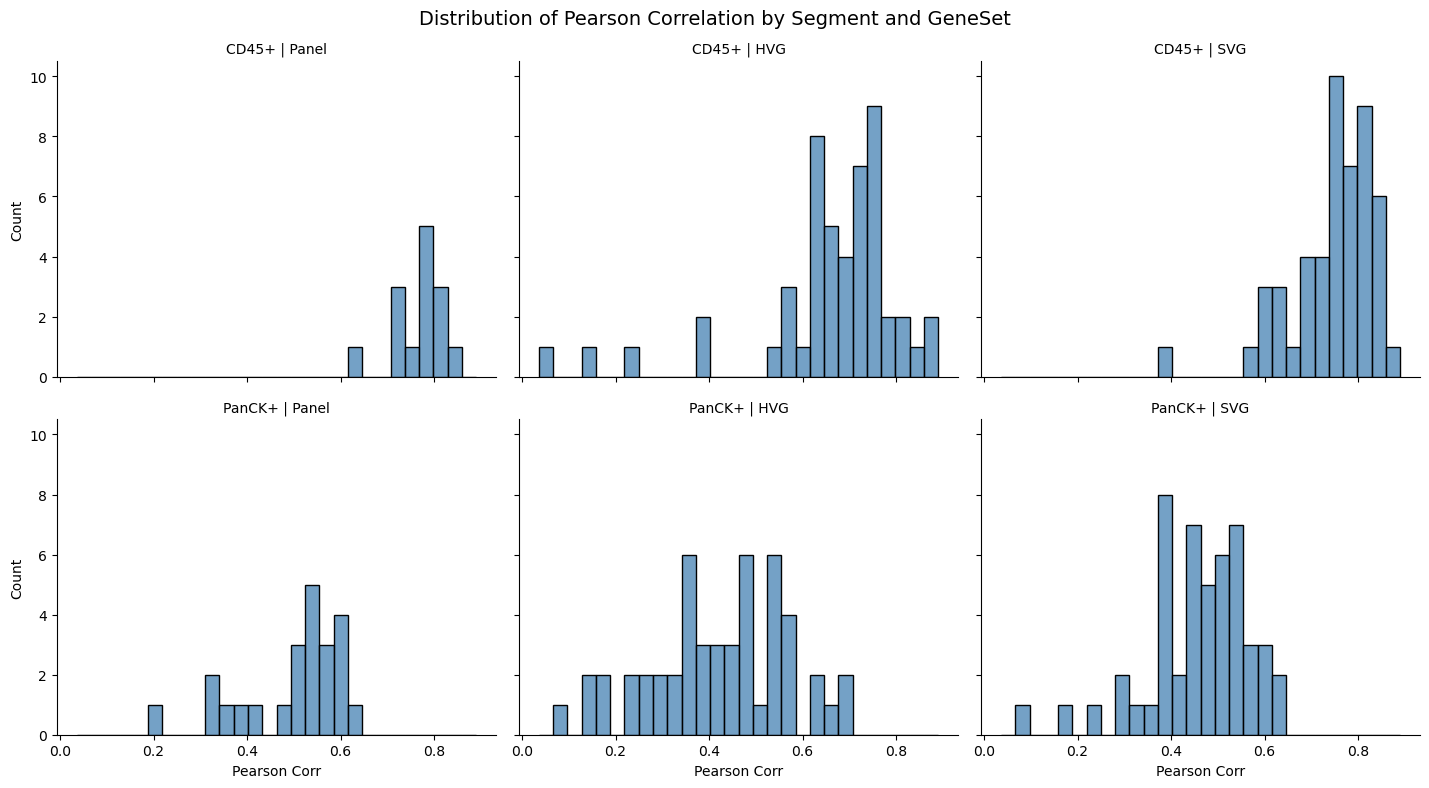

In [65]:
# Compute global bin range
xmin = seg_test_gene_scores['Pearson Corr'].min()
xmax = seg_test_gene_scores['Pearson Corr'].max()

# Set binwidth or number of bins manually
binwidth = 0.03  # You can adjust this
binrange = (xmin, xmax)

# Plot with fixed binrange and binwidth
g = sns.FacetGrid(seg_test_gene_scores, row='Segment', col='GeneSet', height=4, aspect=1.2)
g.map_dataframe(
    sns.histplot,
    x='Pearson Corr',
    binwidth=binwidth,
    binrange=binrange,
    color='steelblue',
    #edgecolor='black'
)
g.set_axis_labels("Pearson Corr", "Count")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.fig.suptitle("Distribution of Pearson Correlation by Segment and GeneSet", fontsize=14)
plt.tight_layout()
plt.show()

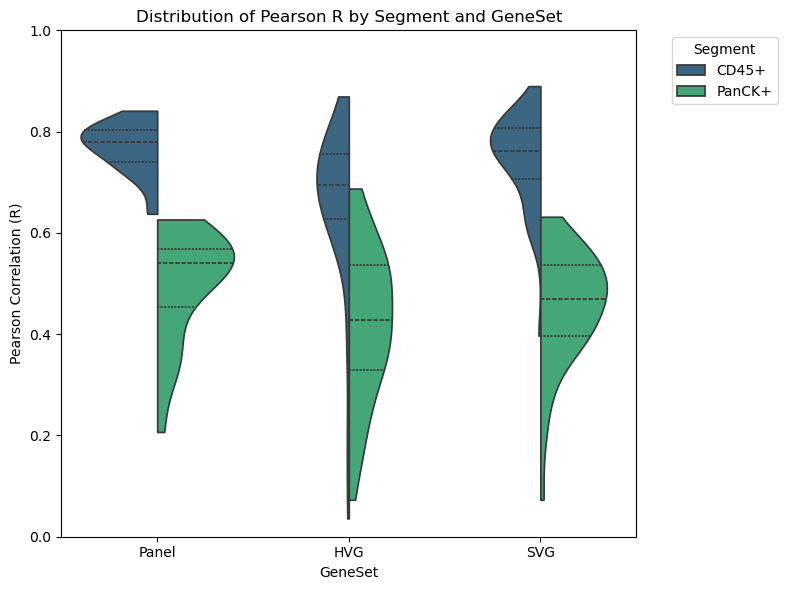

In [66]:
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=seg_test_gene_scores,
    x='GeneSet',
    y='Pearson Corr',
    hue='Segment',
    split=True,             # Half-and-half violins per Segment
    inner='quartile',
    cut=0,
    palette='viridis'
)
plt.title("Distribution of Pearson R by Segment and GeneSet")
plt.ylabel("Pearson Correlation (R)")
plt.xlabel("GeneSet")
plt.ylim(0, 1)
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [67]:
seg_test_gene_scores[seg_test_gene_scores['Segment']=='CD45+'].describe()

,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
count,114.000,114.000,114.000,114.000,114.000,114.000,1.140e+02,1.140e+02,114.000,114.000,114.000,1.140e+02,1.140e+02
mean,1.288,1.046,0.721,0.838,0.460,0.711,6.954e-03,6.975e-03,0.618,0.784,0.695,6.981e-03,7.004e-03
std,1.278,0.443,0.127,0.359,0.218,0.134,6.455e-02,6.458e-02,0.159,0.109,0.121,6.357e-02,6.361e-02
min,0.293,0.541,0.515,0.445,-0.955,0.036,1.907e-45,9.535e-44,-0.137,0.207,0.038,2.971e-39,1.485e-37
25%,0.605,0.778,0.635,0.619,0.379,0.663,7.709e-29,3.309e-28,0.554,0.749,0.659,2.645e-26,1.146e-25
50%,0.820,0.906,0.690,0.742,0.520,0.752,5.710e-25,1.163e-24,0.667,0.819,0.723,2.610e-22,3.924e-22
75%,1.181,1.087,0.785,0.848,0.593,0.789,8.722e-18,1.242e-17,0.714,0.846,0.766,1.589e-17,2.497e-17
max,5.583,2.363,1.393,1.820,0.732,0.890,6.823e-01,6.823e-01,0.847,0.921,0.860,6.679e-01,6.679e-01


In [68]:
seg_test_gene_scores[seg_test_gene_scores['Segment']=='PanCK+'].describe()

,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
count,123.000,123.000,123.000,123.000,123.000,123.000,1.230e+02,1.230e+02,123.000,123.000,123.000,1.230e+02,1.230e+02
mean,1.720,1.277,0.943,1.008,0.098,0.450,7.540e-03,7.609e-03,0.321,0.562,0.450,7.019e-03,7.079e-03
std,0.943,0.300,0.087,0.254,0.173,0.130,4.587e-02,4.593e-02,0.144,0.112,0.127,3.858e-02,3.861e-02
min,0.750,0.866,0.792,0.650,-0.626,0.073,3.859e-24,1.529e-22,-0.082,0.224,0.083,2.037e-22,4.686e-21
25%,1.101,1.049,0.883,0.825,0.021,0.372,5.197e-14,1.667e-13,0.231,0.497,0.375,3.338e-14,1.245e-13
50%,1.538,1.240,0.932,0.974,0.125,0.474,1.573e-10,3.145e-10,0.346,0.585,0.473,1.851e-10,4.871e-10
75%,2.010,1.418,0.987,1.119,0.216,0.545,1.023e-06,1.210e-06,0.428,0.645,0.549,7.954e-07,1.095e-06
max,8.042,2.836,1.271,2.215,0.369,0.687,3.544e-01,3.544e-01,0.597,0.761,0.668,2.901e-01,2.901e-01


In [69]:
good_seg_models = seg_test_gene_scores[seg_test_gene_scores['R2']>0.2].sort_values(by='nRMSE')

In [70]:
good_seg_models.describe()

,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
count,141.000,141.000,141.000,141.000,141.000,141.000,1.410e+02,1.410e+02,141.000,141.000,141.000,1.410e+02,1.410e+02
mean,1.284,1.064,0.736,0.848,0.444,0.696,3.493e-12,7.296e-12,0.601,0.771,0.677,1.885e-11,3.962e-11
std,1.095,0.391,0.101,0.320,0.148,0.102,3.070e-11,6.830e-11,0.123,0.083,0.097,1.232e-10,2.504e-10
min,0.293,0.541,0.515,0.445,0.211,0.466,1.907e-45,9.535e-44,0.337,0.579,0.452,2.971e-39,1.485e-37
25%,0.672,0.820,0.661,0.650,0.305,0.612,9.876e-28,1.883e-27,0.497,0.710,0.598,2.867e-25,1.340e-24
50%,0.941,0.970,0.729,0.754,0.465,0.719,3.070e-22,5.835e-22,0.624,0.793,0.701,4.761e-21,1.565e-20
75%,1.361,1.167,0.831,0.928,0.560,0.779,3.369e-16,6.691e-16,0.701,0.839,0.756,1.101e-15,2.714e-15
max,4.928,2.220,0.886,1.820,0.732,0.890,3.519e-10,7.997e-10,0.847,0.921,0.860,1.339e-09,2.678e-09


## Scatterplots

In [71]:
top_25_panck = good_seg_models[good_seg_models['Segment']=='PanCK+'].sort_values('Pearson Corr', ascending=False)[:25]
top_25_cd45 = good_seg_models[good_seg_models['Segment']=='CD45+'].sort_values('Pearson Corr', ascending=False)[:25]


In [72]:
y_test_cd45 = y_test_cd45.drop_duplicates()
y_pred_cd45 = y_pred_cd45.drop_duplicates()
y_test_panck = y_test_panck.drop_duplicates()
y_pred_panck = y_pred_panck.drop_duplicates()

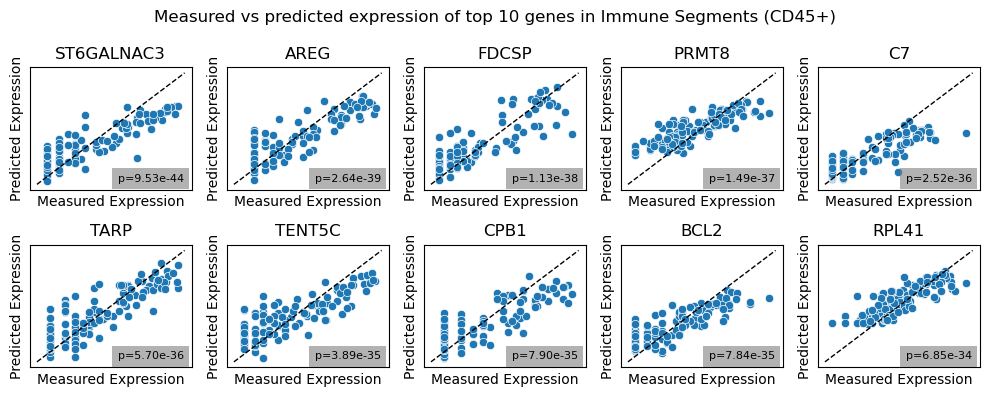

In [73]:
num_genes = 10
ncols=5
nrows=int(num_genes/ncols)

fig, axs = plt.subplots( nrows,ncols, figsize=(10, nrows*2), sharex=False, sharey=False)
axs = axs.flatten()

for i, genename in enumerate(list(top_25_cd45['Gene'][:num_genes])):
    qval = good_seg_models.loc[good_seg_models['Gene']==genename,'PearsonQVals'].values[0]
    pval = good_seg_models.loc[good_seg_models['Gene']==genename,'PearsonPVals'].values[0]
    sns.scatterplot(x=y_test_cd45.loc[genename,:], y=y_pred_cd45.loc[genename,:], ax=axs[i])

    #identity line
    lims = [
        min(axs[i].get_xlim()[0], axs[i].get_ylim()[0]),
        max(axs[i].get_xlim()[1], axs[i].get_ylim()[1])
    ]
    axs[i].plot(lims, lims, '--', color='black', linewidth=1)

    axs[i].text(
        0.95, 0.05, f"p={qval:.2e}",
        transform=axs[i].transAxes,
        fontsize=8, ha='right', va='bottom',
        bbox=dict(facecolor='grey', edgecolor='none', alpha=0.6)
    )


    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("Measured Expression")
    axs[i].set_ylabel("Predicted Expression")
    axs[i].set_title(f"{genename}")
    #plt.plot([y_test_cd45[:, i].min(), y_test_cd45[:, i].max()],
    #        [y_test_cd45[:, i].min(), y_test_cd45[:, i].max()], 'r--')
    #axs[i].grid(True)
#fig.supxlabel(f"True Expression")
#fig.supylabel("Predicted Expression")
fig.suptitle(f"Measured vs predicted expression of top {num_genes} genes in Immune Segments (CD45+)")
plt.tight_layout()
plt.show()

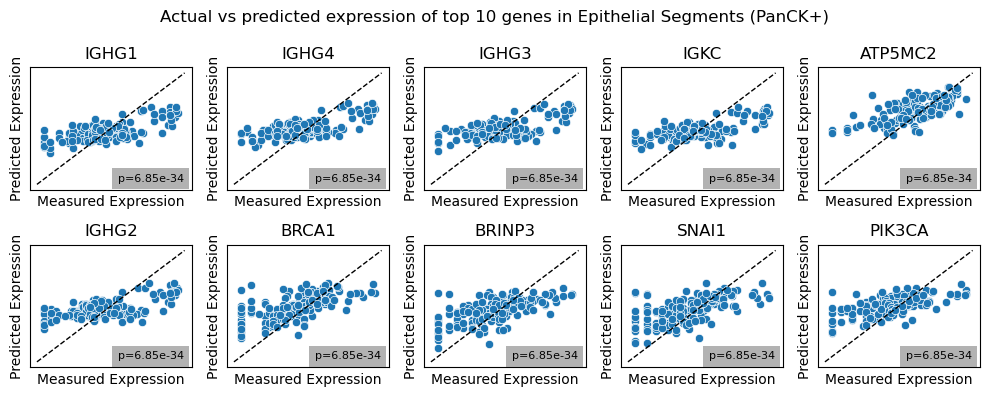

In [74]:
num_genes = 10
ncols=5
nrows=int(num_genes/ncols)

fig, axs = plt.subplots( nrows,ncols, figsize=(10, nrows*2), sharex=False, sharey=False)
axs = axs.flatten()

for i, genename in enumerate(list(top_25_panck['Gene'][:num_genes])):

    sns.scatterplot(x=y_test_panck.loc[genename,:], y=y_pred_panck.loc[genename,:], ax=axs[i])

        #identity line
    lims = [
        min(axs[i].get_xlim()[0], axs[i].get_ylim()[0]),
        max(axs[i].get_xlim()[1], axs[i].get_ylim()[1])
    ]
    axs[i].plot(lims, lims, '--', color='black', linewidth=1)

    axs[i].text(
        0.95, 0.05, f"p={qval:.2e}",
        transform=axs[i].transAxes,
        fontsize=8, ha='right', va='bottom',
        bbox=dict(facecolor='grey', edgecolor='none', alpha=0.6)
    )


    axs[i].set_xticks([])
    axs[i].set_yticks([])

    axs[i].set_xlabel(f"Measured Expression")
    axs[i].set_ylabel("Predicted Expression")
    axs[i].set_title(f"{genename}")
    #plt.plot([y_test_panck[:, i].min(), y_test_panck[:, i].max()],
    #        [y_test_panck[:, i].min(), y_test_panck[:, i].max()], 'r--')
    axs[i].grid(True)

plt.suptitle(f"Actual vs predicted expression of top {num_genes} genes in Epithelial Segments (PanCK+)")
plt.tight_layout()
plt.show()

## Heatmaps

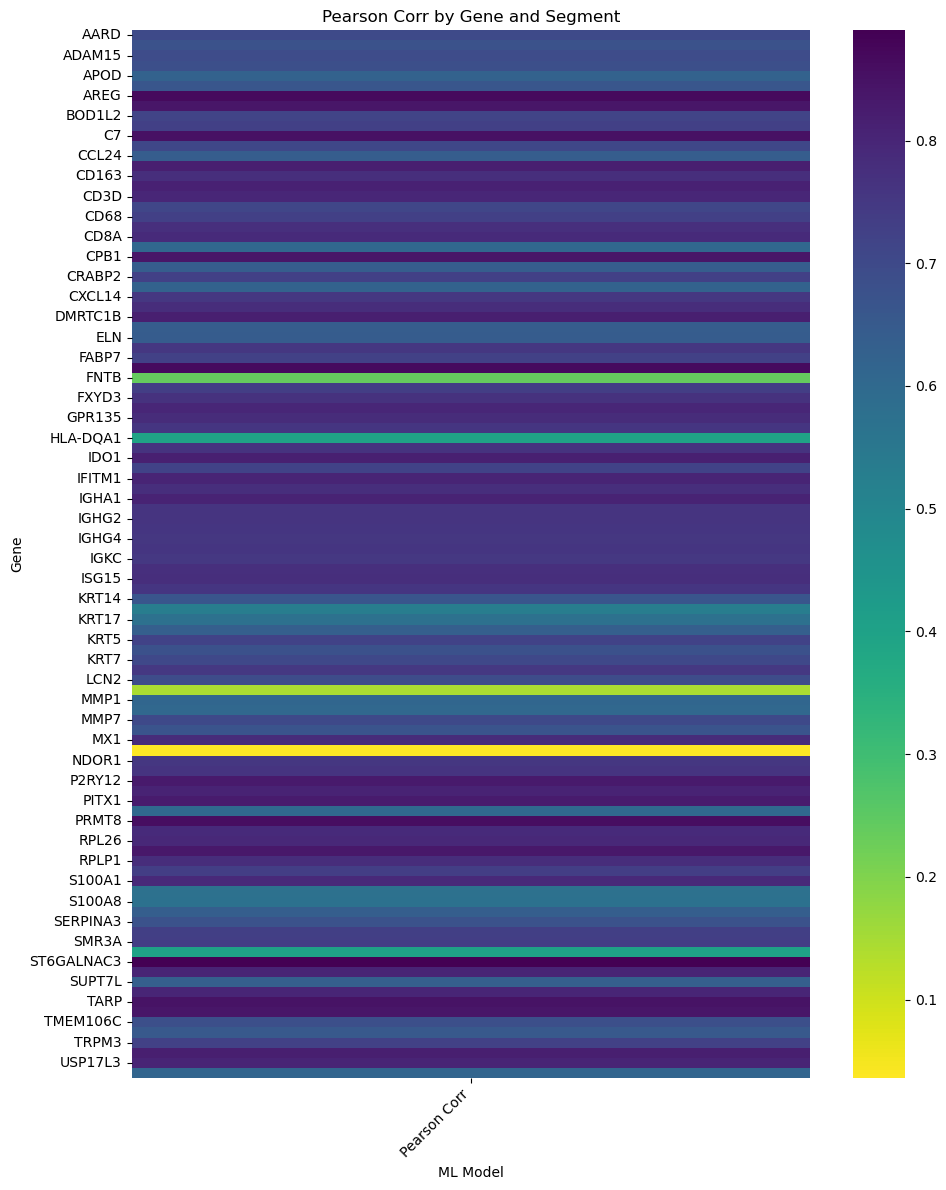

In [75]:
heatmap_data = seg_test_gene_scores[seg_test_gene_scores['Segment']=='CD45+'].pivot_table(index=['Gene'],  values='Pearson Corr')


plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_data, annot=False, cmap='viridis_r')
plt.title("Pearson Corr by Gene and Segment")
plt.xticks(rotation=45, ha='right') 
plt.xlabel("ML Model")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

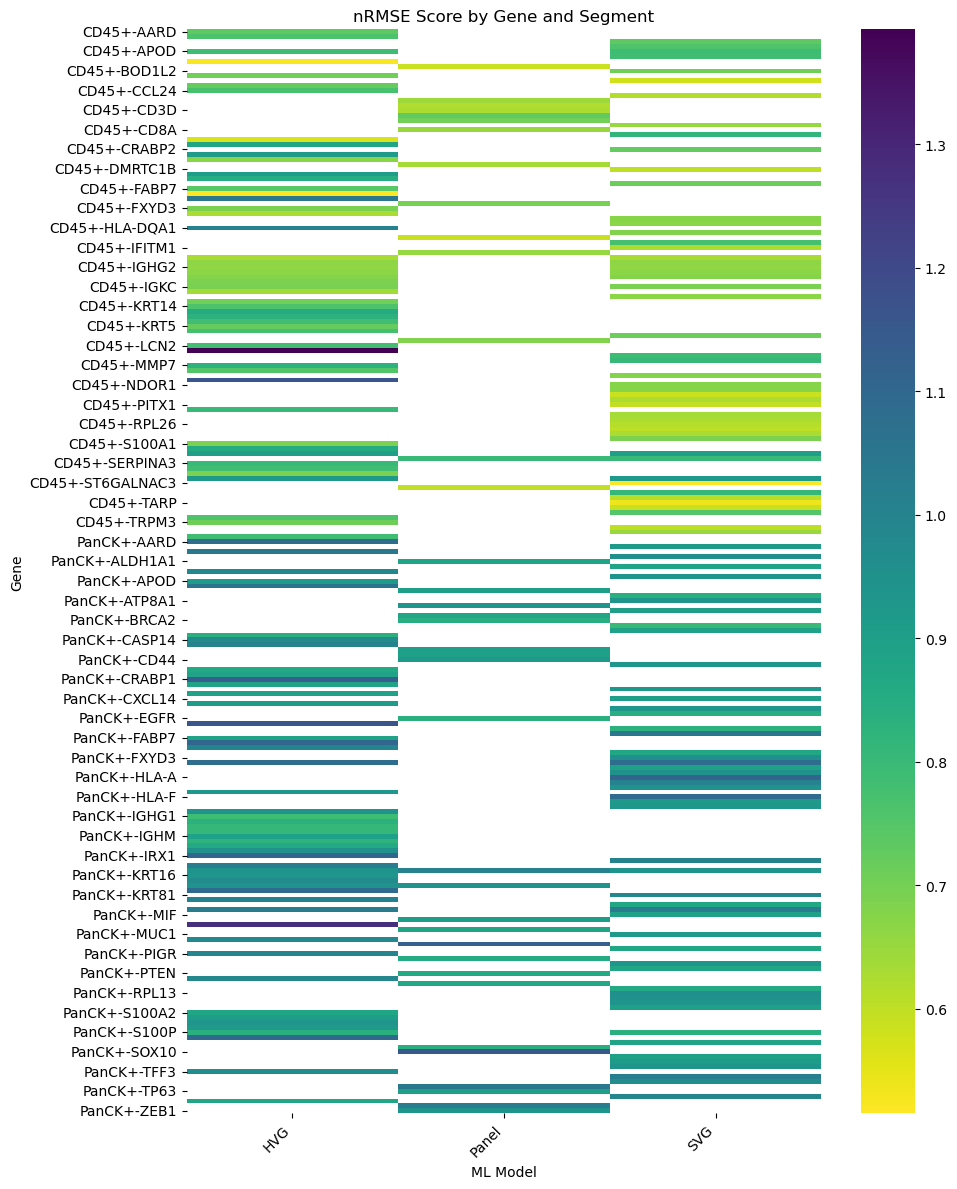

In [76]:
heatmap_data = seg_test_gene_scores.pivot_table(index=['Segment','Gene'], columns=['GeneSet'], values='nRMSE')


plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_data, annot=False, cmap='viridis_r')
plt.title("nRMSE Score by Gene and Segment")
plt.xticks(rotation=45, ha='right') 
plt.xlabel("ML Model")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

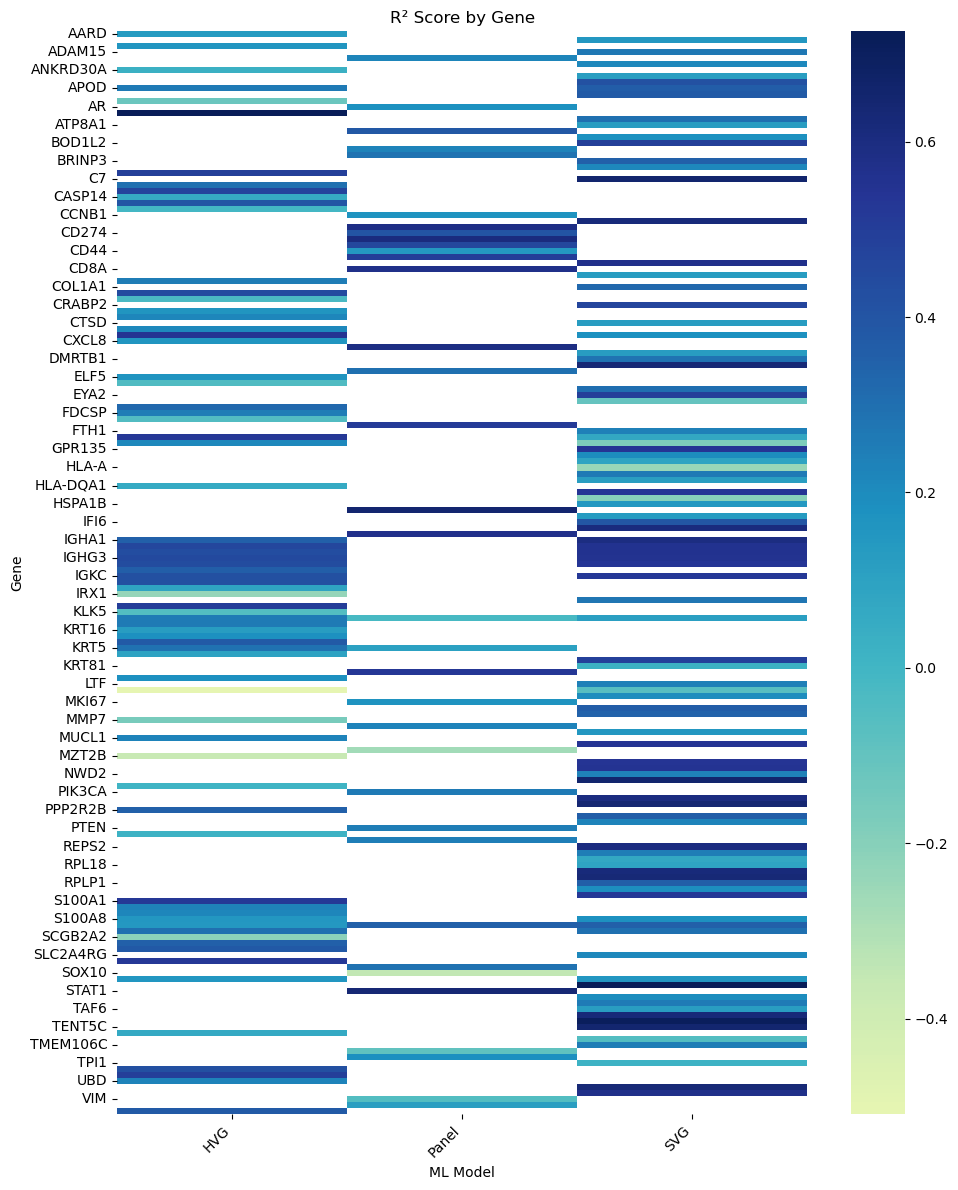

In [77]:
# Pivot table for heatmap
heatmap_data = seg_test_gene_scores.pivot_table(index='Gene', columns=[ 'GeneSet'], values='R2')

plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_data, annot=False, cmap='YlGnBu', center=0.0)
plt.title("R² Score by Gene")
plt.xticks(rotation=45, ha='right') 
plt.xlabel("ML Model")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

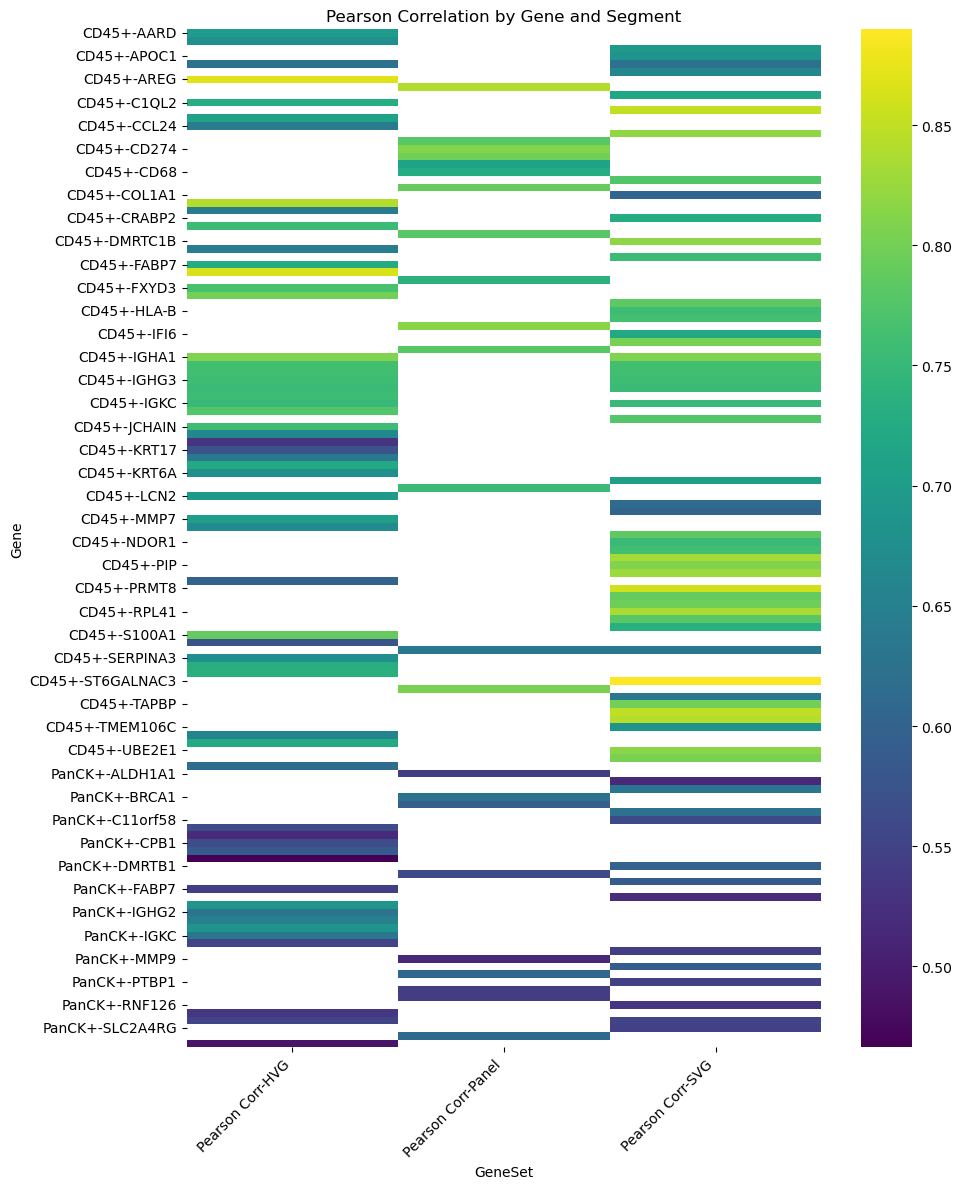

In [78]:
# Pivot table for heatmap
heatmap_data = good_seg_models.pivot_table(index=['Segment','Gene'],  columns=[ 'GeneSet'], values=['Pearson Corr'])

plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_data, annot=False, cmap='viridis')
plt.title("Pearson Correlation by Gene and Segment")
plt.xticks(rotation=45, ha='right') 
plt.xlabel("GeneSet")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

## Plots

### nRMSE by GeneSet

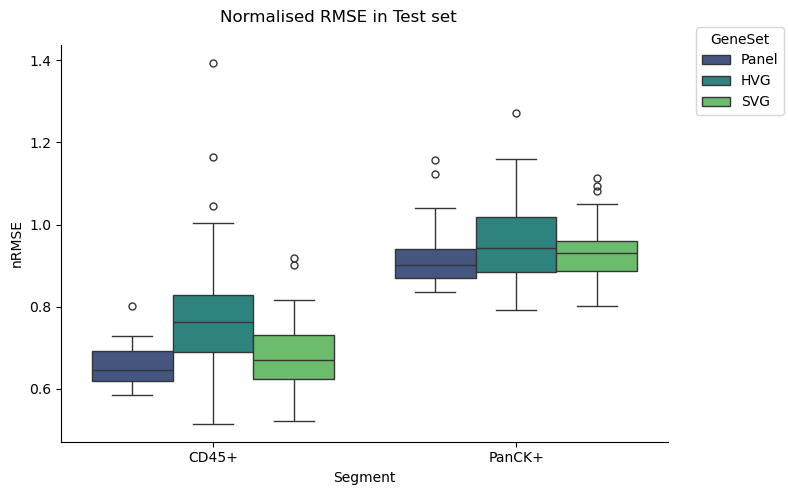

In [79]:


# Set up the FacetGrid to split by 'Segment'
g = sns.catplot(
    data=seg_test_gene_scores,
    x='Segment',
    y='nRMSE',
    hue='GeneSet',
    kind='box',
    height=5,
    aspect=1.2,
    order=segment_order,
    hue_order=geneset_order,
    palette='viridis'
)

# Add titles and formatting
g.set_titles("Segment: {col_name}")
g.set_axis_labels("Segment", "nRMSE")
#g.set(ylim=(0.5, 1.2))  # Set y-axis range
g._legend.set_bbox_to_anchor((1.15,0.95))
g._legend.set_loc('upper right')
g._legend.set_frame_on(True)  
plt.suptitle("Normalised RMSE in Test set")
plt.tight_layout()
plt.show()

Count of significant p-values (e.g., number with p < 0.05)

FDR-adjusted p-values and how many pass q < 0.05

Optionally:

Report median p-value

Or plot a p-value histogram or q–q plot
Mean Pearson ρ	0.38
Genes with p < 0.05	798 / 1000
Genes with FDR q < 0.05	645 / 1000
Median p-value	0.007


significant_count = np.sum(np.array(fdr_adjusted_pvals) < 0.05)
proportion_significant = significant_count / len(fdr_adjusted_pvals)

“Model selection was based on nRMSE across the validation set (mean R² > 0.2). Final model performance was evaluated on a held-out test set not used in model selection. Correlations and p-values reported below reflect test-set-only results.”

Proportion of genes with CI excluding 0 (i.e., significantly non-zero correlation)
“Across 500 genes with R² > 0.2, Pearson ρ 95% CIs ranged from (0.12–0.35) to (0.81–0.91), with a median width of 0.18.”
e.g., immune markers, proliferation genes, or your top 10 predictions

Present: ρ ± CI or ρ (95% CI: low–high)

"We evaluated Pearson correlation between predicted and true gene expression across 104 genes for immune segments and 123 genes in epithelial segments.
A total of XXX genes showed significant correlation after FDR correction (q < 0.05).
The median correlation among these was ρ = 0.42 (IQR: 0.36–0.51), with a median confidence interval width of 0.19.
Top-performing genes included XXXX (ρ = 0.65, 95% CI: 0.51–0.75, q = 0.004) and XXXX (ρ = 0.40, 95% CI: 0.21–0.56, q = 0.034)."

In [80]:
from scipy.stats import combine_pvalues


In [81]:
seg_test_gene_scores.loc[seg_test_gene_scores['Segment']=='CD45+','PearsonPVals']

0      1.585e-31
1      6.724e-28
2      8.510e-28
3      5.598e-36
4      5.588e-30
         ...    
109    1.045e-28
110    1.907e-45
111    4.082e-26
112    8.940e-18
113    4.102e-25
Name: PearsonPVals, Length: 114, dtype: float64

In [82]:
def fisher_with_stat(pvals):
    stat, pval = combine_pvalues(pvals, method='fisher')
    return pd.Series({'FisherStat': stat, 'CombinedPval': pval})


In [83]:
seg_test_gene_scores.head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals
0,Panel,CD45+,virchow,SVM,CD274,0.463,0.680,0.619,0.571,0.614,0.811,1.585e-31,7.398e-31,0.742,0.862,0.785,2.060e-28,7.209e-28
1,Panel,CD45+,virchow,SVM,CXCL9,1.080,1.039,0.635,0.765,0.594,0.781,6.724e-28,1.345e-27,0.703,0.840,0.774,3.358e-27,7.835e-27
2,Panel,CD45+,virchow,SVM,IFNG,0.382,0.618,0.655,0.491,0.568,0.780,8.510e-28,1.489e-27,0.702,0.839,0.728,9.651e-23,1.351e-22
3,Panel,CD45+,virchow,SVM,BCL2,0.485,0.697,0.586,0.577,0.654,0.841,5.598e-36,7.837e-35,0.782,0.885,0.805,8.568e-31,8.449e-30
4,Panel,CD45+,virchow,SVM,CD3D,0.549,0.741,0.624,0.548,0.607,0.798,5.588e-30,1.565e-29,0.726,0.853,0.800,3.737e-30,1.744e-29


In [84]:
1.590e-02

0.0159

In [85]:
seg_test_gene_scores['CI_width'] = seg_test_gene_scores['PearsonCI_high']-seg_test_gene_scores['PearsonCI_low']

In [86]:
seg_test_gene_scores.groupby(['Segment','GeneSet'])[['Pearson Corr','R2','PearsonQVals','CI_width']].mean()

Pearson Corr     R2  PearsonQVals  CI_width
Segment GeneSet                                             
CD45+   HVG             0.658  0.371     1.590e-02     0.188
        Panel           0.769  0.560     2.406e-17     0.142
        SVG             0.747  0.521     5.767e-08     0.152
PanCK+  HVG             0.421  0.062     1.108e-02     0.247
        Panel           0.499  0.127     3.518e-04     0.229
        SVG             0.456  0.121     7.474e-03     0.241

In [87]:
seg_test_gene_scores.groupby(['Segment','GeneSet'])[['PearsonCI_high','PearsonCI_low']].max()

PearsonCI_high  PearsonCI_low
Segment GeneSet                               
CD45+   HVG               0.906          0.820
        Panel             0.885          0.782
        SVG               0.921          0.847
PanCK+  HVG               0.761          0.597
        Panel             0.712          0.523
        SVG               0.716          0.530

In [88]:
(seg_test_gene_scores
    .groupby(['Segment','GeneSet'])['PearsonPVals']
    .apply(lambda pvals: combine_pvalues(pvals.values, method='fisher')[0])
    .reset_index()
    .rename(columns={'PearsonPVals':'FisherStat'})
)
#stat, combined_p = combine_pvalues(pvals, method='fisher')

,Segment,GeneSet,FisherStat
0,CD45+,HVG,4444.976
1,CD45+,Panel,1708.222
2,CD45+,SVG,5820.824
3,PanCK+,HVG,2063.897
4,PanCK+,Panel,1240.003
5,PanCK+,SVG,2253.507


In [89]:
(seg_test_gene_scores['PearsonQVals'] < 0.05)

0      True
1      True
2      True
3      True
4      True
       ... 
232    True
233    True
234    True
235    True
236    True
Name: PearsonQVals, Length: 237, dtype: bool

In [90]:
sig_prop = seg_test_gene_scores.assign(Significant = seg_test_gene_scores['PearsonPVals'] < 0.001).groupby(['Segment', 'GeneSet'])['Significant'].mean()
sig_prop

Segment  GeneSet
CD45+    HVG        0.940
         Panel      1.000
         SVG        1.000
PanCK+   HVG        0.860
         Panel      0.957
         SVG        0.940
Name: Significant, dtype: float64

# Analyse Results

C:\Users\hooll\AppData\Local\Temp\ipykernel_4040\2519274475.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(["Immune Regions (CD45+)", "Tumour Regions (PanCK+)"])


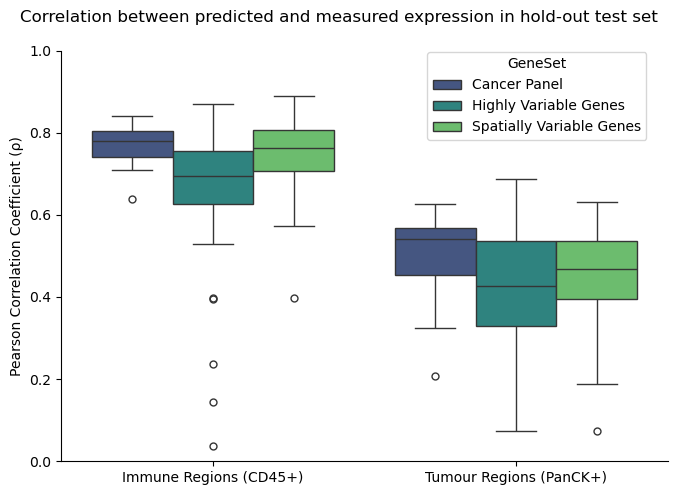

In [139]:


# Set up the FacetGrid to split by 'Segment'
g = sns.catplot(
    data=seg_test_gene_scores,
    x='Segment',
    y='Pearson Corr',
    hue='GeneSet',
    kind='box',
    height=5,
    aspect=1.2,
    order=segment_order,
    hue_order=geneset_order,
    palette='viridis'
)

# Add titles and formatting
g.set_titles("Segment: {col_name}")
g.set_axis_labels("", "Pearson Correlation Coefficient (ρ)")
g.set(ylim=(0.0, 1.0))  # Set y-axis range
#g.add_legend(title='GeneSet', loc='upper left', labels=['Cancer Panel', 'Highly', 'Spat'])
g._legend.set_bbox_to_anchor((0.95,0.9))
g._legend.set_loc('upper right')
g._legend.set_frame_on(True)  
# replace labels
new_labels = ['Cancer Panel', 'Highly Variable Genes','Spatially Variable Genes']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

g.ax.set_xticklabels(["Immune Regions (CD45+)", "Tumour Regions (PanCK+)"])

plt.suptitle("Correlation between predicted and measured expression in hold-out test set")
plt.tight_layout()
plt.show()

C:\Users\hooll\AppData\Local\Temp\ipykernel_4040\823257244.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(["Immune Regions (CD45+)", "Tumour Regions (PanCK+)"])


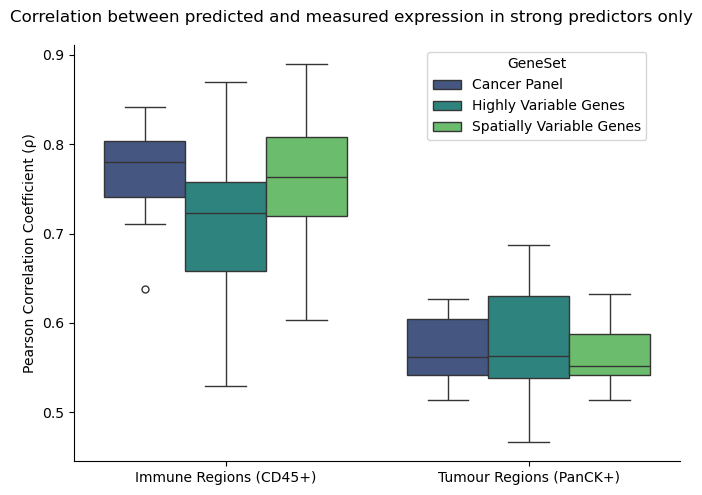

In [140]:


# Set up the FacetGrid to split by 'Segment'
g = sns.catplot(
    data=good_seg_models,
    x='Segment',
    y='Pearson Corr',
    hue='GeneSet',
    kind='box',
    height=5,
    aspect=1.2,
    order=segment_order,
    hue_order=geneset_order,
    palette='viridis'
)

# Add titles and formatting
g.set_titles("Segment: {col_name}")
g.set_axis_labels("", "Pearson Correlation Coefficient (ρ)")
#g.set(ylim=(0.5, 1.2))  # Set y-axis range
g._legend.set_bbox_to_anchor((0.95,0.9))
g._legend.set_loc('upper right')
g._legend.set_frame_on(True)  

new_labels = ['Cancer Panel', 'Highly Variable Genes','Spatially Variable Genes']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

g.ax.set_xticklabels(["Immune Regions (CD45+)", "Tumour Regions (PanCK+)"])

plt.suptitle("Correlation between predicted and measured expression in strong predictors only")
plt.tight_layout()
plt.show()

## Compare scores

In [141]:
print("unique genes:")
print(f"R2 > 0.2: {seg_test_gene_scores[seg_test_gene_scores['R2']>0.2]['Gene'].nunique()}")
print(f"R2 > 0.3: {seg_test_gene_scores[seg_test_gene_scores['R2']>0.3]['Gene'].nunique()}")
print(f"R2 > 0.4: {seg_test_gene_scores[seg_test_gene_scores['R2']>0.4]['Gene'].nunique()}")

unique genes:
R2 > 0.2: 124
R2 > 0.3: 94
R2 > 0.4: 74


In [142]:

seg_test_gene_scores.groupby('Segment')[['nRMSE','R2','Pearson Corr','Spearman Corr']].aggregate('mean')

,nRMSE,R2,Pearson Corr,Spearman Corr
Segment,,,,
CD45+,0.721,0.460,0.711,0.695
PanCK+,0.943,0.098,0.450,0.450


In [143]:

good_seg_models.groupby('Segment')[['nRMSE','R2','Pearson Corr','Spearman Corr']].aggregate('mean')

,nRMSE,R2,Pearson Corr,Spearman Corr
Segment,,,,
CD45+,0.694,0.509,0.740,0.721
PanCK+,0.855,0.264,0.571,0.553


# Examine Gene-Level predictions

Which genes have the best predictive performance?

In [144]:
cond = (seg_test_gene_scores['Segment']=='CD45+')&(seg_test_gene_scores['R2']>0.2) #&(seg_test_gene_scores['GeneSet']=='HVG')#

In [145]:
seg_test_gene_scores[cond].sort_values('nRMSE',ascending=True).head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals,CI_width
15,HVG,CD45+,virchow,SVM,FDCSP,0.672,0.820,0.515,0.599,0.732,0.865,4.506e-40,1.126e-38,0.814,0.902,0.842,4.525e-36,2.262e-34,0.089
110,SVG,CD45+,virchow,SVM,ST6GALNAC3,0.531,0.729,0.522,0.615,0.726,0.890,1.907e-45,9.535e-44,0.847,0.921,0.833,1.147e-34,1.912e-33,0.073
62,HVG,CD45+,virchow,SVM,AREG,0.607,0.779,0.524,0.643,0.724,0.869,5.273e-41,2.637e-39,0.820,0.906,0.795,1.516e-29,2.527e-28,0.086
103,SVG,CD45+,virchow,SVM,TARP,0.373,0.611,0.536,0.479,0.710,0.848,4.556e-37,5.695e-36,0.791,0.890,0.822,4.356e-33,5.445e-32,0.099
45,HVG,CD45+,virchow,SVM,CPB1,0.293,0.541,0.567,0.445,0.677,0.842,4.739e-36,7.898e-35,0.783,0.885,0.770,1.002e-26,1.002e-25,0.103


In [146]:
seg_test_gene_scores[cond].sort_values('nRMSE',ascending=True).head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals,CI_width
15,HVG,CD45+,virchow,SVM,FDCSP,0.672,0.820,0.515,0.599,0.732,0.865,4.506e-40,1.126e-38,0.814,0.902,0.842,4.525e-36,2.262e-34,0.089
110,SVG,CD45+,virchow,SVM,ST6GALNAC3,0.531,0.729,0.522,0.615,0.726,0.890,1.907e-45,9.535e-44,0.847,0.921,0.833,1.147e-34,1.912e-33,0.073
62,HVG,CD45+,virchow,SVM,AREG,0.607,0.779,0.524,0.643,0.724,0.869,5.273e-41,2.637e-39,0.820,0.906,0.795,1.516e-29,2.527e-28,0.086
103,SVG,CD45+,virchow,SVM,TARP,0.373,0.611,0.536,0.479,0.710,0.848,4.556e-37,5.695e-36,0.791,0.890,0.822,4.356e-33,5.445e-32,0.099
45,HVG,CD45+,virchow,SVM,CPB1,0.293,0.541,0.567,0.445,0.677,0.842,4.739e-36,7.898e-35,0.783,0.885,0.770,1.002e-26,1.002e-25,0.103


In [147]:
seg_test_gene_scores[cond].sort_values('Pearson Corr',ascending=False).head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals,CI_width
110,SVG,CD45+,virchow,SVM,ST6GALNAC3,0.531,0.729,0.522,0.615,0.726,0.890,1.907e-45,9.535e-44,0.847,0.921,0.833,1.147e-34,1.912e-33,0.073
62,HVG,CD45+,virchow,SVM,AREG,0.607,0.779,0.524,0.643,0.724,0.869,5.273e-41,2.637e-39,0.820,0.906,0.795,1.516e-29,2.527e-28,0.086
15,HVG,CD45+,virchow,SVM,FDCSP,0.672,0.820,0.515,0.599,0.732,0.865,4.506e-40,1.126e-38,0.814,0.902,0.842,4.525e-36,2.262e-34,0.089
72,SVG,CD45+,virchow,SVM,PRMT8,0.943,0.971,0.633,0.789,0.596,0.859,5.965e-39,1.491e-37,0.805,0.898,0.860,2.971e-39,1.485e-37,0.093
87,SVG,CD45+,virchow,SVM,C7,0.473,0.688,0.580,0.542,0.661,0.851,1.515e-37,2.524e-36,0.795,0.892,0.785,2.200e-28,1.000e-27,0.097


In [148]:
seg_test_gene_scores[cond].sort_values('Spearman Corr',ascending=False).head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals,CI_width
72,SVG,CD45+,virchow,SVM,PRMT8,0.943,0.971,0.633,0.789,0.596,0.859,5.965e-39,1.491e-37,0.805,0.898,0.860,2.971e-39,1.485e-37,0.093
15,HVG,CD45+,virchow,SVM,FDCSP,0.672,0.820,0.515,0.599,0.732,0.865,4.506e-40,1.126e-38,0.814,0.902,0.842,4.525e-36,2.262e-34,0.089
75,SVG,CD45+,virchow,SVM,RPL41,0.801,0.895,0.604,0.690,0.633,0.834,8.219e-35,6.849e-34,0.772,0.880,0.837,2.485e-35,6.213e-34,0.107
110,SVG,CD45+,virchow,SVM,ST6GALNAC3,0.531,0.729,0.522,0.615,0.726,0.890,1.907e-45,9.535e-44,0.847,0.921,0.833,1.147e-34,1.912e-33,0.073
103,SVG,CD45+,virchow,SVM,TARP,0.373,0.611,0.536,0.479,0.710,0.848,4.556e-37,5.695e-36,0.791,0.890,0.822,4.356e-33,5.445e-32,0.099


In [149]:
cond = (seg_test_gene_scores['Segment']=='PanCK+')#&(seg_test_gene_scores['R2']>0.2)

In [150]:
seg_test_gene_scores[cond].sort_values('nRMSE',ascending=True).head()

,GeneSet,Segment,Feature_Extractor,Model,Gene,MSE,RMSE,nRMSE,MAE,R2,Pearson Corr,PearsonPVals,PearsonQVals,PearsonCI_low,PearsonCI_high,Spearman Corr,SpearmanPVals,SpearmanQVals,CI_width
145,HVG,PanCK+,uni,SVM,IGHG1,2.243,1.498,0.792,1.216,0.369,0.687,3.859e-24,1.529e-22,0.597,0.761,0.536,1.626e-13,9.036e-13,0.164
211,SVG,PanCK+,uni,SVM,BRINP3,0.837,0.915,0.803,0.711,0.351,0.626,4.395e-19,1.099e-17,0.522,0.711,0.652,4.424e-21,2.212e-19,0.189
161,HVG,PanCK+,uni,SVM,IGHG3,2.072,1.440,0.808,1.157,0.343,0.649,6.723e-21,1.120e-19,0.551,0.730,0.465,4.023e-10,8.381e-10,0.180
156,HVG,PanCK+,uni,SVM,IGHG4,2.404,1.550,0.810,1.278,0.340,0.685,6.118e-24,1.529e-22,0.594,0.759,0.507,5.250e-12,2.019e-11,0.165
155,HVG,PanCK+,uni,SVM,IGKC,2.488,1.577,0.824,1.262,0.316,0.632,1.494e-19,1.867e-18,0.530,0.716,0.468,2.895e-10,6.580e-10,0.186


# Figure 7

## Top 10 genes by segment

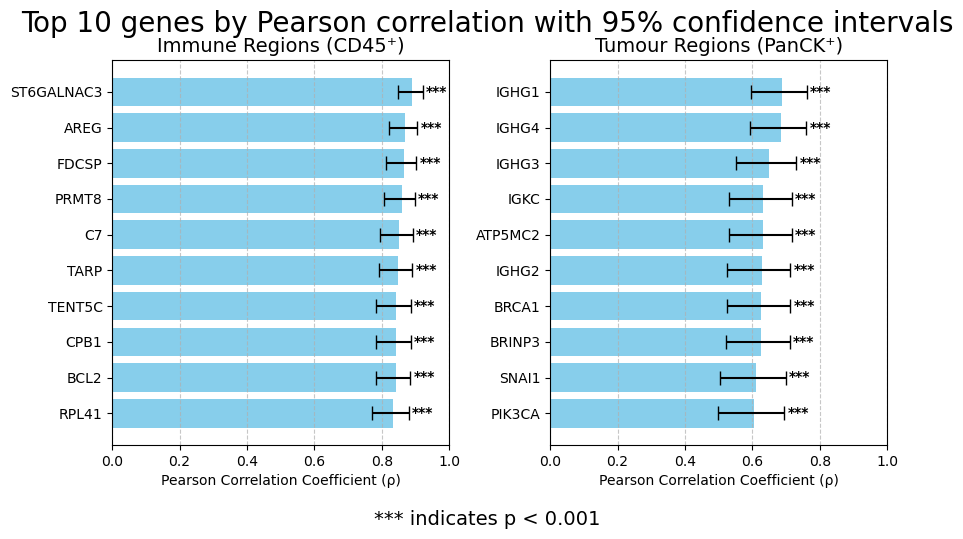

In [151]:
num_genes = 10
df = good_seg_models.copy()
df["ci_lower_error"] = df["Pearson Corr"] - df["PearsonCI_low"]
df["ci_upper_error"] = df["PearsonCI_high"] - df["Pearson Corr"]
df["ci_lower_error"] = df["ci_lower_error"].clip(lower=0)
df["ci_upper_error"] = df["ci_upper_error"].clip(lower=0)



# Select top 10 genes by Pearson_r (or use q-value filter if preferred)
top_genes_panck = df[df['Segment']=='PanCK+'].nlargest(num_genes, "Pearson Corr").copy()
top_genes_cd45 = df[df['Segment']=='CD45+'].nlargest(num_genes, "Pearson Corr").copy()

# Sort for visual clarity
top_genes_panck = top_genes_panck.sort_values("Pearson Corr", ascending=True)
top_genes_cd45 = top_genes_cd45.sort_values("Pearson Corr", ascending=True)


fig, axes = plt.subplots(1, 2, figsize=(10, 5),gridspec_kw={'wspace': 0.3} ) 


axes[0].barh(
    top_genes_cd45["Gene"],
    top_genes_cd45["Pearson Corr"],
    xerr=[top_genes_cd45["ci_lower_error"], top_genes_cd45["ci_upper_error"]],
    align='center',
    ecolor='black',
    capsize=5,
    color='skyblue'
)

for i, (val, upper_err, qval) in enumerate(zip(
    top_genes_cd45["Pearson Corr"],
    top_genes_cd45["ci_upper_error"],
    top_genes_cd45["PearsonQVals"]
)):
    if qval <= 0.001:
        sig = "***"
    elif qval <= 0.01:
        sig = "**"
    elif qval <= 0.05:
        sig = "*"
    else:
        sig = ""
    xpos = val + upper_err + 0.01  # add small offset to avoid overlap
    axes[0].text(xpos, i, sig, va='center', fontsize=10, fontweight='bold')

axes[0].set_xlabel("Pearson Correlation Coefficient (ρ)")
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].set_title('Immune Regions (CD45⁺)', fontsize=14)
axes[0].set_xlim((0,1.0))


axes[1].barh(
    top_genes_panck["Gene"],
    top_genes_panck["Pearson Corr"],
    xerr=[top_genes_panck["ci_lower_error"], top_genes_panck["ci_upper_error"]],
    align='center',
    ecolor='black',
    capsize=5,
    color='skyblue'
)
for i, (val, upper_err, qval) in enumerate(zip(
    top_genes_panck["Pearson Corr"],
    top_genes_panck["ci_upper_error"],
    top_genes_panck["PearsonQVals"]
)):
    if qval <= 0.001:
        sig = "***"
    elif qval <= 0.01:
        sig = "**"
    elif qval <= 0.05:
        sig = "*"
    else:
        sig = ""
    xpos = val + upper_err + 0.01  # add small offset to avoid overlap
    axes[1].text(xpos, i, sig, va='center', fontsize=10, fontweight='bold')

axes[1].set_xlabel("Pearson Correlation Coefficient (ρ)")
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_title('Tumour Regions (PanCK⁺)', fontsize=14)
axes[1].set_xlim((0,1.0))


plt.suptitle(f"Top {num_genes} genes by Pearson correlation with 95% confidence intervals", fontsize=20)
plt.figtext(0.5, -0.05, '*** indicates p < 0.001', ha='center', fontsize=14)

plt.show()


In [ ]:
cond = (seg_test_gene_scores['Segment']=='PanCK+')&(seg_test_gene_scores['R2']>0.2)&(seg_test_gene_scores['GeneSet']=='Panel')

In [ ]:
list(seg_test_gene_scores.loc[cond,'Gene'] )

In [ ]:
cond = (seg_test_gene_scores['Segment']=='CD45+')&(seg_test_gene_scores['R2']>0.2)&(seg_test_gene_scores['GeneSet']=='Panel')

In [ ]:
list(seg_test_gene_scores.loc[cond,'Gene'])

# Signatures

In [ ]:
all_sig_scores = pd.read_csv(os.path.join(root_path,'SignatureScores.csv'))
all_sig_scores = all_sig_scores.drop(columns=['index'])
all_sig_scores.head()

In [ ]:
segment = 'PanCK+'
feat_extr = best_per_segment.loc[best_per_segment['Segment']==segment,'Feature_Extractor'].values[0]
model = best_per_segment.loc[best_per_segment['Segment']==segment,'ML_Model'].values[0]
geneset='signatures'

In [ ]:
feat_extr='gigapath'
model='SVM'

In [ ]:
all_sig_scores.head()

In [ ]:
seed=77

In [ ]:
# sig_test_scores_list = []
# sig_test_gene_scores_list = []


# print(f"****** {geneset} | {segment} | {feat_extr} | {model} ******")
    
# X_train, y_train = load_data(geneset, feat_extr, segment)
# print("Feature Matrix Shape:", X_train.shape)
# print("Outcome Shape:", len(y_train))  # Should match the number of images

# ## Get the hyperparameters selected during CV 
# cond = (all_sig_scores['Segment']==segment)
# cond = cond & (all_sig_scores['Feature_Extractor']==feat_extr)
# cond = cond & (all_sig_scores['ML_Model']==model)
# params_subset = all_sig_scores.loc[cond,['Signature','Params']]


# if not all(params_subset['Signature'].values == y_train.drop(columns='LEAP_ID').columns):
#     print("Sorting params")
#     params_subset = (
#         params_subset.set_index('Gene')
#         .reindex(y_train.drop(columns='LEAP_ID').columns)
#         .reset_index()
#         .rename(columns={'index': 'Gene'})  # in case the name gets lost
#     )
#     #raise ValueError("params_subset['Gene'] is not in the same order as y_train.columns")
# else:
#     print("OK")


    
# ######### TRAIN MODELS ###########################################
# if model=='SVM':
#     base_model = SVR()
# elif model=='elasticnet':
#     base_model = ElasticNet(random_state=seed)
# elif model=='gradboost':
#     base_model = HistGradientBoostingRegressor(random_state=seed)
# else:
#     print("model not recognised")

    

# y_train = y_train.drop(columns=['LEAP_ID'])
# trained_models = train_final_regressor(base_model, X_train, y_train, list(params_subset['Signature']), list(params_subset['Params']))


# ###################################################################################
# ######### EVALUATE ON HOLD OUT TEST SET ###########################################
# ###################################################################################

# #### LOAD DATA ####################################################################
# X_test, y_test = load_data(geneset, feat_extr, segment, test=True)
# print("Feature Matrix Shape:", X_test.shape)
# print("Outcome Shape:", len(y_test))  # Should match the number of images


# #### EVALUATE ######################################################################
# y_test = y_test.drop(columns=['LEAP_ID'])
# summary_scores, per_gene_scores = evaluate_final_models(trained_models, X_test, y_test,
#                                                             geneset, segment, feat_extr, model,
#                                                             output_path=save_path)
# sig_test_scores_list.append(summary_scores)
# sig_test_gene_scores_list.append(per_gene_scores)
# final_models[(segment,geneset)] = {g:m for g, m in zip(list(y_test.columns), trained_models)}


In [ ]:
# sig_test_scores = pd.concat(sig_test_scores_list, ignore_index=True, sort=False)
# sig_test_gene_scores = pd.concat(sig_test_gene_scores_list, ignore_index=True, sort=False)
# sig_test_gene_scores

## Analyse


In [ ]:
# sig_good_models = sig_test_gene_scores[sig_test_gene_scores['R2']>0.2].sort_values(by='nRMSE')

In [ ]:
# sig_test_gene_scores.sort_values('R2',ascending=False)

In [ ]:
# print("unique genes:")
# print(f"R2 > 0.1: {sig_test_gene_scores[sig_test_gene_scores['R2']>0.1]['Gene'].nunique()}")
# print(f"R2 > 0.2: {sig_test_gene_scores[sig_test_gene_scores['R2']>0.2]['Gene'].nunique()}")
# print(f"R2 > 0.3: {sig_test_gene_scores[sig_test_gene_scores['R2']>0.3]['Gene'].nunique()}")

In [ ]:
# heatmap_data = sig_test_gene_scores.pivot_table(index=['Gene'], values='nRMSE')


# plt.figure(figsize=(10, 12)) 
# sns.heatmap(heatmap_data, annot=False, cmap='viridis_r')
# plt.title("nRMSE Score by Gene and Segment")
# plt.xticks(rotation=45, ha='right') 
# plt.xlabel("ML Model")
# plt.ylabel("Gene")
# plt.tight_layout()
# plt.show()

In [ ]:
# sig_test_gene_scores.sort_values('Pearson Corr', ascending=False)

In [ ]:

# sns.set_palette(sns.color_palette("colorblind"))

# # Set up the FacetGrid to split by 'Segment'
# g = sns.catplot(
#     data=sig_test_gene_scores,
#     x='Segment',
#     y='nRMSE',
#     kind='box',
#     height=5,
#     aspect=1.2,
#     order=segment_order,
#     hue_order=geneset_order
# )

# # Add titles and formatting
# g.set_axis_labels("Segment", "nRMSE")
# #g.set(ylim=(0.5, 1.2))  # Set y-axis range
# plt.suptitle("Normalised RMSE in Test set")
# plt.tight_layout()
# plt.show()

# Overlay Measured vs Predicted Expression

In [ ]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from skimage.transform import resize

In [ ]:
from LEAPdata import get_slide_id
from visualize import overlay_coords_on_img, plot_rois_on_image, display_spatial_expression, single_violin
from PIL import Image
import PIL

# Increase the image pixel limit
PIL.Image.MAX_IMAGE_PIXELS = None  # Removes the limit entirely

### Viz functions

In [ ]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

def plot_patient_row(fig, gs_row, image_gt, image_pred, values_gt, values_pred,
                     rois, sample_metadata, leap_id, limits, cmap='seismic',
                     show_titles=False, ds=0.2):
    rect_w = 224*ds
    vmin = min(values_gt.min(), values_pred.min())
    vmax = max(values_gt.max(), values_pred.max())+0.5

    cmap = mpl.colormaps[cmap]  if isinstance(cmap, str) else cmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # Left label
    ax_label = fig.add_subplot(gs_row[0])
    ax_label.axis('off')
    ax_label.text(0.95, 0.5, leap_id, fontsize=18, ha='right', va='center', transform=ax_label.transAxes,rotation=45 )

    # Ground Truth
    ax_gt = fig.add_subplot(gs_row[1])
    ax_gt.imshow(image_gt)
    for x, y, val in zip(sample_metadata.loc[rois, "scatter_x"],
                         sample_metadata.loc[rois, "scatter_y"],
                         values_gt):
        
        color = cmap(norm(val)) 
        rect = patches.Rectangle((x - rect_w/2, y - rect_w/2), rect_w, rect_w, facecolor=color, edgecolor=None, alpha=0.95)
        ax_gt.add_patch(rect)
    if show_titles:
        ax_gt.set_title("Measured Expression", fontsize=18)
    ax_gt.set_xlim(limits[0])
    ax_gt.set_ylim(limits[1])
    ax_gt.axis('off')
    ax_gt.set_aspect('auto')
    # Prediction
    
    # Prediction
    ax_pred = fig.add_subplot(gs_row[2])
    ax_pred.imshow(image_pred)
    for x, y, val in zip(sample_metadata.loc[rois, "scatter_x"],
                         sample_metadata.loc[rois, "scatter_y"],
                         values_pred):
        color = cmap(norm(val))
        rect = patches.Rectangle((x - rect_w/2, y - rect_w/2), rect_w, rect_w, facecolor=color, edgecolor=None, alpha=0.8)
        ax_pred.add_patch(rect)
    if show_titles:
        ax_pred.set_title("Predicted Expression", fontsize=18)
    ax_pred.set_xlim(limits[0])
    ax_pred.set_ylim(limits[1])
    ax_pred.axis('off')
    ax_pred.set_aspect('auto')

    # Colorbar
    cbar_ax = inset_axes(
        ax_pred,           # attach to the predicted image plot
        width="3%",        # % of parent width
        height="100%",     # match height of ax_pred
        loc='center left',
        bbox_to_anchor=(1.02, 0., 1, 1),
        bbox_transform=ax_pred.transAxes,
        borderpad=0
    )
    cb = plt.colorbar(sm, cax=cbar_ax)
    cb.set_label("Expression Level", fontsize=14)
    # 1) force integer tick *locations*
    cb.locator = MaxNLocator(integer=True)  
    # 2) force integer tick *formatting*
    cb.formatter = FormatStrFormatter("%d")
    cb.update_ticks()


In [ ]:


def plot_roiexpr_on_he(he_img, y_test, y_pred, rois, gene, subset_metadata, xlim=None, ylim=None,ds=1.0):
   
    gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns
    rect_w = 224 * ds

    y_test = y_test.loc[rois,:]
    y_pred = y_pred.loc[rois,:]
    subset_metadata = subset_metadata.loc[rois,:]
    #print(subset_metadata['scatter_x'])

    vmin = min(y_test[gene].min(), y_pred[gene].min())
    vmax = max(y_test[gene].max(), y_pred[gene].max())
    cmap = plt.cm.seismic #bwr #autumn #plt.cm.hot  # or 'viridis', etc.

    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

    # Shared colormap normalizer
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=cmap, norm=norm)

    for ax, values, title in zip(axes, [y_test[gene], y_pred[gene]],
                                [f"Ground Truth Expression of {gene}",
                                f"Predicted Expression of {gene}"]):

        ax.imshow(he_img)
        
        for x, y, val in zip(
            subset_metadata["scatter_x"],
            subset_metadata["scatter_y"],
            values
        ):
            color = cmap(norm(val))
            rect = patches.Rectangle(
                (x - rect_w/2, y - rect_w/2), rect_w, rect_w,  # (left, bottom), width, height
                linewidth=0,
                edgecolor=None,
                facecolor=color,
                alpha=0.8
            )
            ax.add_patch(rect)

        ax.set_title(title)
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        if ylim: ax.set_ylim(ylim)
        if xlim: ax.set_xlim(xlim)

    # Add colorbars
    for ax in axes:
        plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)

    plt.suptitle(f'Actual vs Predicted Gene Expression - {segment} {gene}')
    plt.tight_layout()#
    
    plt.show()


In [ ]:

def plot_roirank_on_he(he_img, y_test, y_pred, rois, gene, subset_metadata, xlim=None, ylim=None,ds=1.0):
   
    gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns
    rect_w = 224 * ds


    #vmin = min(y_test[gene].min(), y_pred[gene].min())
    #vmax = max(y_test[gene].max(), y_pred[gene].max())
    #print(y_test.loc[rois,:])
    y_test = y_test.loc[rois,:]
    y_pred = y_pred.loc[rois,:]
    subset_metadata = subset_metadata.loc[rois,:]

    cmap = plt.cm.seismic #bwr #autumn #plt.cm.hot  # or 'viridis', etc.

    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

    
    #print(y_test[gene])
    for ax, values, title in zip(axes, [y_test[gene], y_pred[gene]],
                                [f"Ground Truth Expression of {gene}",
                                f"Predicted Expression of {gene}"]):
        # Independent normalization for this axis
        vmin, vmax = values.min(), values.max()
        #print(f"v: {vmin} - {vmax}")
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Required for colorbar

        ax.imshow(he_img)
        
        for x, y, val in zip(
            subset_metadata["scatter_x"],
            subset_metadata["scatter_y"],
            values
        ):
            color =  plt.cm.seismic((val - vmin) / (vmax - vmin)) 
            rect = patches.Rectangle(
                (x - rect_w/2, y - rect_w/2), rect_w, rect_w,  # (left, bottom), width, height
                linewidth=0,
                edgecolor=None,
                facecolor=color,
                alpha=0.8
            )
            ax.add_patch(rect)

        ax.set_title(title)
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        if ylim: ax.set_ylim(ylim)
        if xlim: ax.set_xlim(xlim)

    # Add colorbars
    #for ax in axes:
    #    plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)

    sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)
    plt.suptitle(f'Actual vs Predicted Gene Expression - {segment} {gene}')
    plt.tight_layout()#
    
    plt.show()

In [ ]:

def plot_expr_on_he_both(he_img, y_test, y_pred, rois, gene, subset_metadata, xlim=None, ylim=None):
   
    gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns


    y_test = y_test.loc[rois,:]
    y_pred = y_pred.loc[rois,:]
    subset_metadata = subset_metadata.loc[rois,:]


    vmin1 = min(y_test[gene].min(), y_pred[gene].min())
    vmax1 = max(y_test[gene].max(), y_pred[gene].max())
    vmin2 = vmin1
    vmax2 = vmax1


    fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
    axes = axes.flatten()

    ## INDIVIDUAL SCALES
    # Plot 1: Ground Truth
    sc1 = axes[0].imshow(he_img)
    scatter1 = axes[0].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_test[gene], cmap="seismic", alpha=1
    )
    axes[0].set_title(f"Ground Truth Expression of {gene}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    if ylim: axes[0].set_ylim(ylim)
    if xlim: axes[0].set_xlim(xlim)
    plt.colorbar(scatter1, ax=axes[0], label="Expression Level",shrink=0.75)

    # Plot 2: Prediction
    sc2 = axes[1].imshow(he_img)
    scatter2 = axes[1].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_pred[gene], cmap="seismic", alpha=1
    )
    axes[1].set_title(f"Predicted Expression of {gene}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    if ylim: axes[1].set_ylim(ylim)
    if xlim: axes[1].set_xlim(xlim)
    plt.colorbar(scatter2, ax=axes[1], label="Expression Level",shrink=0.75)


    ## SHARED SCALES
    # Plot 1: Ground Truth
    sc1 = axes[2].imshow(he_img)
    scatter1 = axes[2].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_test[gene], cmap="seismic", alpha=1, vmin=vmin1,vmax=vmax1
    )
    axes[2].set_title(f"Ground Truth Expression of {gene}")
    axes[2].set_xlabel("X Coordinate")
    axes[2].set_ylabel("Y Coordinate")
    if ylim: axes[2].set_ylim(ylim)
    if xlim: axes[2].set_xlim(xlim)
    plt.colorbar(scatter1, ax=axes[2], label="Expression Level",shrink=0.75)

    # Plot 2: Prediction
    sc2 = axes[3].imshow(he_img)
    scatter2 = axes[3].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_pred[gene], cmap="seismic", alpha=1, vmin=vmin2,vmax=vmax2
    )
    axes[3].set_title(f"Predicted Expression of {gene}")
    axes[3].set_xlabel("X Coordinate")
    axes[3].set_ylabel("Y Coordinate")
    if ylim: axes[3].set_ylim(ylim)
    if xlim: axes[3].set_xlim(xlim)
    plt.colorbar(scatter2, ax=axes[3], label="Expression Level",shrink=0.75)



    plt.suptitle(f'Actual vs Predicted Gene Expression - {segment} {gene}')
    plt.tight_layout()#
    
    plt.show()

In [ ]:


def plot_expr_on_he(he_img, y_test, y_pred_np, rois, gene, subset_metadata, xlim=None, ylim=None,downsample_factor=0.2, same_scale=True):
   
    gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns

    y_pred = pd.DataFrame(y_pred_np, index=y_test.index, columns=gene_cols)

    y_test = y_test.loc[rois,:]
    y_pred = y_pred.loc[rois,:]
    subset_metadata = subset_metadata.loc[rois,:]


    if same_scale:
        vmin1 = min(y_test[gene].min(), y_pred[gene].min())
        vmax1 = max(y_test[gene].max(), y_pred[gene].max())
        vmin2 = vmin1
        vmax2 = vmax1
    else:
        vmin1 = y_test[gene].min()
        vmax1 = y_test[gene].max()
        vmin2 = y_pred[gene].min()
        vmax2 = y_pred[gene].max()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

    # Plot 1: Ground Truth
    sc1 = axes[0].imshow(he_img)
    scatter1 = axes[0].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_test[gene], cmap="seismic", alpha=1, vmin=vmin1,vmax=vmax1
    )
    axes[0].set_title(f"Ground Truth Expression of {gene}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    if ylim: axes[0].set_ylim(ylim)
    if xlim: axes[0].set_xlim(xlim)
    plt.colorbar(scatter1, ax=axes[0], label="Expression Level",shrink=0.75)

    # Plot 2: Prediction
    sc2 = axes[1].imshow(he_img)
    scatter2 = axes[1].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_pred[gene], cmap="seismic", alpha=1, vmin=vmin2,vmax=vmax2
    )
    axes[1].set_title(f"Predicted Expression of {gene}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    if ylim: axes[1].set_ylim(ylim)
    if xlim: axes[1].set_xlim(xlim)
    plt.colorbar(scatter2, ax=axes[1], label="Expression Level",shrink=0.75)

    plt.suptitle(f'Actual vs Predicted Gene Expression - {segment} {geneset} {gene}')
    plt.tight_layout()#
    
    plt.show()


In [ ]:
def plot_expr_compare(he_img, y_test, y_pred_np, rois, gene, subset_metadata, xlim=None, ylim=None):
   
    gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns

    y_pred = pd.DataFrame(y_pred_np, index=y_test.index, columns=gene_cols)

    y_test = y_test.loc[rois,:]
    y_pred = y_pred.loc[rois,:]
    subset_metadata = subset_metadata.loc[rois,:]

    vmin1 = min(y_test[gene].min(), y_pred[gene].min())
    vmax1 = max(y_test[gene].max(), y_pred[gene].max())
    vmin2 = vmin1
    vmax2 = vmax1

    fig, axes = plt.subplots(1, 3, figsize=(14, 5)) 

    # Plot 1: Ground Truth
    sc1 = axes[0].imshow(he_img)
    scatter1 = axes[0].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_test[gene], cmap="seismic", alpha=1, vmin=vmin1,vmax=vmax1
    )
    axes[0].set_title(f"Ground Truth Expression of {gene}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    if ylim: axes[0].set_ylim(ylim)
    if xlim: axes[0].set_xlim(xlim)
    plt.colorbar(scatter1, ax=axes[0], label="Expression Level",shrink=0.75)

    # Plot 2: Prediction
    sc2 = axes[1].imshow(he_img)
    scatter2 = axes[1].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_pred[gene], cmap="seismic", alpha=1, vmin=vmin2,vmax=vmax2
    )
    axes[1].set_title(f"Predicted Expression of {gene}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    if ylim: axes[1].set_ylim(ylim)
    if xlim: axes[1].set_xlim(xlim)
    plt.colorbar(scatter2, ax=axes[1], label="Expression Level",shrink=0.75)

    # Plot 3: Prediction on own axis
    sc2 = axes[2].imshow(he_img)
    scatter2 = axes[2].scatter(
        subset_metadata['scatter_x'], 
        subset_metadata['scatter_y'], 
        c=y_pred[gene], cmap="seismic", alpha=1
    )
    axes[2].set_title(f"Predicted Expression of {gene}")
    axes[2].set_xlabel("X Coordinate")
    axes[2].set_ylabel("Y Coordinate")
    if ylim: axes[2].set_ylim(ylim)
    if xlim: axes[2].set_xlim(xlim)
    plt.colorbar(scatter2, ax=axes[2], label="Expression Level",shrink=0.75)

    plt.suptitle(f'Actual vs Predicted Gene Expression - {segment} {geneset} {gene}')
    plt.tight_layout()#
    
    plt.show()

In [ ]:

img_path = 'E:/01-data/LEAP/WSI/2-aligned/10x/cleaned'
OME_LEVEL = 2 # should be level 1 but haven't extracted at 20x yet
DOWNSAMPLE = 2**OME_LEVEL

In [ ]:

metadata_path = 'C:/Users/hooll/Dropbox/19 PostGrad/00 CB Lab/01 projects/06 MultiModal/data/LEAP'
sample_metadata = pd.read_excel(os.path.join(metadata_path,"full_meta_data.xlsx"), index_col=0)

In [ ]:
sample_metadata["ROICoordinateX_downsampled"] = (sample_metadata["ROICoordinateX"] / DOWNSAMPLE).astype(int)
sample_metadata["ROICoordinateY_downsampled"] = (sample_metadata["ROICoordinateY"] / DOWNSAMPLE).astype(int)

### Genes of Interest

In [ ]:
# genes_of_interest = {}
# genes_of_interest[('CD45+','Panel')] = ['CXCL9', 'CD68', 'STAT1', 'S100A9'] #Panel
# genes_of_interest[('CD45+','HVG')] = ['MUCL1', 'CALML5', 'TPSAB1', 'KRT6A', 'S100A8', 'S100A7', 'KRT17']
# genes_of_interest[('CD45+','SVG')] = ['TENT5C','CCSAP', 'ST6GALNAC3', 'UBE2E1', 'CD82', 'DMRTC1B', 
#                                       'EYA2', 'REPS2','P2RY12','PIP','BOD1L2',
#                                       'RPLP1','PRMT8','RPL41'] #HVG/SVG
# genes_of_interest[('PanCK+','Panel')] = ['PIK3CA', 'EGFR', 'MKI67', 'BRCA1','PTEN'] #Panel
# genes_of_interest[('PanCK+','HVG')] = ['CA9', 'LCN2', 'AQP3', 'IGHM','AARD','ELN','CPB1','CSN3']
# genes_of_interest[('PanCK+','SVG')] = ['ADAM15','SUPT7L']

In [ ]:
genes_of_interest = {}
genes_of_interest[('CD45+','Panel')] = ['BCL2', 'IDO1', 'STAT1', 'CD274', 'CD3D', 'CXCL9'] #Panel
genes_of_interest[('CD45+','HVG')] = ['AREG','FDCSP','CPB1']
genes_of_interest[('CD45+','SVG')] = ['ST6GALNAC3','PRMT8','C7','TARP', 'TENT5C','RPL41','P2RY12','PITX1','CCSAP' ] #/SVG
genes_of_interest[('PanCK+','Panel')] = ['BRCA1', 'SNAI1', 'PIK3CA', 'BRCA2', 'EGFR'] #Panel
genes_of_interest[('PanCK+','HVG')] = ['IGHG1', 'IGHG4', 'IGHG3', 'IGKC',  'IGHG2',   'CSN3', 'CA9', 'CPB1' ]
genes_of_interest[('PanCK+','SVG')] = ['ATP5MC2', 'BRINP3', 'DMRTB1', 'NWD2', 'ENO1']

In [ ]:
good_seg_models[good_seg_models['Gene']=='EGFR']

In [ ]:
cd45_rois['LEAP_ID'].unique()

In [ ]:
panck_rois['LEAP_ID'].unique()

### Set LEAP ID

order of highest variance
cd45: ['LEAP120', 'LEAP079', 'LEAP121', 'LEAP078', 'LEAP082', 'LEAP045']
panck: ['LEAP065', 'LEAP094', 'LEAP121', 'LEAP120', 'LEAP082', 'LEAP093', 'LEAP064', 'LEAP079']

In [ ]:
leaporder =  ['LEAP120', 'LEAP121','LEAP065', 'LEAP079','LEAP082', 'LEAP093', 'LEAP064', 'LEAP045']

In [ ]:
limits = {}
limits['LEAP045'] = ((200,12000),(11600,5000))
limits['LEAP032'] = ((2200,5500),(2000,0))
limits['LEAP064'] = ((2300,11300),(19500,14500))
limits['LEAP065'] = ((2000,11000),(7500,2500))
limits['LEAP078'] = ((1200,5000),(7100,4500))
limits['LEAP079'] = ((0,11000),(7600,200))
limits['LEAP082'] = ((800,8200),(4100,0))
limits['LEAP093'] = ((3000,7500),(11000,8500))
limits['LEAP120'] = ((1700,11300),(22000,16700))
limits['LEAP121'] = ((1000,9100),(4500,0))

In [ ]:
LEAPID='LEAP120'

In [ ]:
leaprois = {}
leaprois['CD45+'] = list(cd45_rois[cd45_rois['LEAP_ID']==LEAPID].index)
leaprois['PanCK+'] = list(panck_rois[panck_rois['LEAP_ID']==LEAPID].index)

In [ ]:
downsample_factor=0.2
    # --- Adjust ROI coordinates to match downsampled image ---
sample_metadata.loc[:, 'scatter_x'] = sample_metadata.loc[:,"ROICoordinateY_downsampled"] * downsample_factor
sample_metadata.loc[:, 'scatter_y']  = sample_metadata.loc[:,"ROICoordinateX_downsampled"] * downsample_factor

In [ ]:
subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==LEAPID]

In [ ]:
# Load H&E
heimgs = {}
for leap in leaporder:
    slide=get_slide_id(leap)
    he_path = os.path.join(img_path,f"{leap}_{slide.lower()}-aligned.tiff")
    he_img = Image.open(he_path)
    he_img = np.array(he_img)
    # --- Downsample image ---
    downsampled_img = resize(he_img, 
                            output_shape=(int(he_img.shape[0]*downsample_factor), 
                                        int(he_img.shape[1]*downsample_factor)),
                            anti_aliasing=True,
                            preserve_range=True).astype(he_img.dtype)
    heimgs[leap] = downsampled_img


In [ ]:
# # 
# # --- Downsample image ---
# downsampled_img = resize(he_img, 
#                             output_shape=(int(he_img.shape[0]*downsample_factor), 
#                                         int(he_img.shape[1]*downsample_factor)),
#                             anti_aliasing=True,
#                             preserve_range=True).astype(he_img.dtype)


In [ ]:
scaled_limits = {
    k: (
        tuple(int(x * downsample_factor) for x in v[0]),  # xlim
        tuple(int(y * downsample_factor) for y in v[1])   # ylim
    )
    for k, v in limits.items()
}
scaled_limits

Genes of Interest

In [ ]:
genelist_cd45 = ['BCL2','CPB1', 'IDO1', 'ST6GALNAC3', 'CD3D', 'FDCSP', 'C7', 'P2RY12']
genelist_panck = ['CPB1', 'ENO1']

In [ ]:

leaprois['PanCK+'] = list(panck_rois[panck_rois['LEAP_ID']==LEAPID].index)

In [ ]:

gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns


In [ ]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# import colorsys



# # Choose fixed hue and lightness, vary saturation from low to high
# hue = 160 / 360        # e.g. purple (280°)
# lightness = 0.6      # mid brightness
# saturations = [i / 19 for i in range(1, 20)]  # from 0.1 to 1.0

# palette = [
#     colorsys.hls_to_rgb(hue, lightness, s)
#     for s in saturations
# ]
# sns.palplot(palette)
# cmap = mcolors.ListedColormap(palette, name='custom_purple')

In [ ]:

# from matplotlib.colors import LinearSegmentedColormap
# #cmap = LinearSegmentedColormap.from_list("saturation_map", palette, N=256)
# #cmap = sns.cubehelix_palette(start=.6, rot=-.1, as_cmap=True) 
# cmap = mcolors.ListedColormap(palette, name='custom_greens')
# fig, ax = plt.subplots(figsize=(1, 4))
# fig.subplots_adjust(left=0.5)

# cb = plt.colorbar(ScalarMappable(cmap=cmap), cax=ax)
# cb.set_label("Colormap scale")
# plt.show()

# Figure 6

## Plot H&E

### CD45+

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.patches import Rectangle

gene='ST6GALNAC3'
#gene='AREG'
#gene='FDCSP'
#gene='PRMT8'
leap_ids = ['LEAP120','LEAP121']#,'LEAP064']#,'LEAP082','LEAP093']
fig = plt.figure(figsize=(10, 2.8 * len(leap_ids)), layout='constrained')
gs = GridSpec(len(leap_ids), 4, width_ratios=[0.1, 1, 1, 0.05], figure=fig, wspace=0.05)

n_rows = len(leap_ids)

row_height = 1 / n_rows
#col = sns.light_palette("#2dd9f8", n_colors=20, as_cmap=True)
# col = sns.color_palette("crest_r", as_cmap=True) <----- v1
col = sns.color_palette("seismic", as_cmap=True) 
col = sns.color_palette("YlOrRd", as_cmap=True) 

#mcolors.ListedColormap(palette, name='custom_greens')
#sns.cubehelix_palette(start=2.7, rot=0, dark=.4, light=.9,hue=1,gamma=1.6, n_colors=8,as_cmap=True)
#col=sns.cubehelix_palette(start=2.7, rot=0, dark=.4, light=.9,hue=1,gamma=1.6, n_colors=8,as_cmap=True) 
#col = sns.color_palette("dark:#5A9_r",as_cmap=True)
#col=sns.cubehelix_palette(hue=1,start=2,dark=.25, light=.85, as_cmap=True) #sns.dark_palette("#028f46", as_cmap=True)
#col =sns.dark_palette("#2dd9f8", n_colors=10, as_cmap=True)

for i, leap_id in enumerate(leap_ids):
    rois = list(cd45_rois[cd45_rois['LEAP_ID'] == leap_id].index)
    values_gt = y_test_cd45.T.loc[rois, gene]
    values_pred = y_pred_cd45.T.loc[rois, gene]
    lim = scaled_limits[leap_id]
    image = heimgs[leap_id]

    gs_row = gs[i, :]  # This is a SubplotSpec
    sub_gs = GridSpecFromSubplotSpec(
            1, 4,
            subplot_spec=gs_row,
            width_ratios=[0.1, 1, 1, 0.05],
            wspace=0.05
        )
    plot_patient_row(
        fig,
        sub_gs,
        image, image,
        values_gt,
        values_pred,
        rois,
        sample_metadata,
        f"Patient {i+1}",
        lim, cmap=col,
        show_titles=(i == 0)  # Only show titles on first row
    )

    row_y = 1 - (i + 1) / n_rows
    # Adjust margins if needed (e.g., make left/right padding smaller)

#fig.patch.set_facecolor('#f0f0f0')  # light grey
fig.suptitle(f'Expression of {gene} in immune regions', fontsize=24)
#fig.subplots_adjust(top=0.9, bottom=0.05)
#fig.subplots_adjust(top=0.95, bottom=0.05, left=0.08, right=0.98, wspace=0.2, hspace=0.15)
plt.show()

# Overlay

### PanCK+

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.patches import Rectangle

#gene='IGHG1'
#gene='IGHG4'
gene='IGHG3'
gene='IGKC'
gene='ATP5MC2'
gene='BRCA1'
gene='BRINP3'
#gene='SNAI1'
#gene='PIK3CA'
#gene='CD247'
leap_ids = ['LEAP120','LEAP121','LEAP064','LEAP082','LEAP093']
fig = plt.figure(figsize=(10, 2.8 * len(leap_ids)), layout='constrained')
gs = GridSpec(len(leap_ids), 4, width_ratios=[0.1, 1, 1, 0.05], figure=fig, wspace=0.05)

n_rows = len(leap_ids)

row_height = 1 / n_rows
col = sns.light_palette("#2dd9f8", n_colors=20, as_cmap=True)
col = sns.color_palette("crest_r", as_cmap=True)
#mcolors.ListedColormap(palette, name='custom_greens')
#sns.cubehelix_palette(start=2.7, rot=0, dark=.4, light=.9,hue=1,gamma=1.6, n_colors=8,as_cmap=True)
#sns.cubehelix_palette(start=2.7, rot=0, dark=.4, light=.9,hue=1,gamma=1.6, n_colors=8,as_cmap=True) #sns.color_palette("dark:#5A9_r",as_cmap=True)
#sns.cubehelix_palette(hue=1,start=2,dark=.25, light=.75, as_cmap=True) #sns.dark_palette("#028f46", as_cmap=True)
#sns.dark_palette("#2dd9f8", n_colors=10, as_cmap=True)

for i, leap_id in enumerate(leap_ids):
    rois = list(panck_rois[panck_rois['LEAP_ID'] == leap_id].index)
    values_gt = y_test_panck.T.loc[rois, gene]
    values_pred = y_pred_panck.T.loc[rois, gene]
    limits = scaled_limits[leap_id]
    image = heimgs[leap_id]

    gs_row = gs[i, :]  # This is a SubplotSpec
    sub_gs = GridSpecFromSubplotSpec(
            1, 4,
            subplot_spec=gs_row,
            width_ratios=[0.1, 1, 1, 0.05],
            wspace=0.05
        )
    plot_patient_row(
        fig,
        sub_gs,
        image, image,
        values_gt,
        values_pred,
        rois,
        sample_metadata,
        f"Patient {i+1}",
        limits, cmap=col,
        show_titles=(i == 0)  # Only show titles on first row
    )

    row_y = 1 - (i + 1) / n_rows
    # Adjust margins if needed (e.g., make left/right padding smaller)

#fig.patch.set_facecolor('#f0f0f0')  # light grey
fig.suptitle(f'Expression of {gene} in tumour segments (PanCK+)')
#fig.subplots_adjust(top=0.9, bottom=0.05)
#fig.subplots_adjust(top=0.95, bottom=0.05, left=0.08, right=0.98, wspace=0.2, hspace=0.15)
plt.show()

## Plot ROIs with registration

In [ ]:
from visualize import overlay_coords_on_img, plot_rois_on_image

In [ ]:
img_path = 'E:/01-data/LEAP/WSI'

In [ ]:
LEAPID='LEAP121'
SLIDE_ID=get_slide_id(LEAPID)
SLIDE_ID

In [ ]:
# Load H&E
he_path = os.path.join(img_path,'2-aligned','10x','cleaned',f"{LEAPID}_{SLIDE_ID.lower()}-aligned.tiff")
print(he_path)
he_img_reg = Image.open(he_path)
he_img_reg = np.array(he_img_reg)
he_img_reg.shape

Slide_48 _LEAP121

In [ ]:
# Load H&E original
he_path = os.path.join(img_path,'1-transformations','10x-tif',f"{SLIDE_ID.upper()}_{LEAPID}.tif")
he_path = os.path.join(img_path,'1-transformations','10x-tif',f"{SLIDE_ID}_{LEAPID}.tif")
he_img_orig = Image.open(he_path)
he_img_orig = np.array(he_img_orig)
he_img_orig.shape

In [ ]:
SLIDE_ID

In [ ]:
# Load H&E original
path='E:/01-data/LEAP/OME-TIFF/1-converted/10x'
if_path = os.path.join(path,f"{LEAPID}-{SLIDE_ID}.tif")
if_img = Image.open(if_path)
if_img = np.array(if_img)
if_img.shape

In [ ]:
subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==LEAPID]

{'ROI:0': {'x': 1874, 'y': 539, 'width': 282, 'height': 282, 'name': 'Roi'},
roi num: x:ROICoordinateX_downsampled, y:ROICoordinateY_downsampled, w, h, name

In [ ]:
subset_metadata.head(3)

In [ ]:
def plot_rois(img, metadata, ax=None, limits=None, title='ROIs Overlaid on Image',lw=2):

    rect_w=244
    ax.imshow(img)



    #for roi_id, rect in roi_dict.items():
    for x, y, roi_id in zip(metadata["ROICoordinateY_downsampled"],
                            metadata["ROICoordinateX_downsampled"],
                            metadata["Roi"]):
        # Extract rectangle data
        
        #print(f"roi {roi_id} : {x}, {y}")
        # Create a rectangle patch
        rectangle = patches.Rectangle(
            (x - rect_w/2, y - rect_w/2),  # Bottom-left corner
            rect_w,   # Width
            rect_w,  # Height
            linewidth=lw,
            edgecolor='blue',
            facecolor='none'
        )
        # Add the rectangle to the plot
        ax.add_patch(rectangle)

        # Add the ROI ID as a label
        ax.text(
            x,  # Center of the rectangle (x)
            y,  # Center of the rectangle (y)
            #roi_id,          # ROI ID label
            int(roi_id),          # ROI ID label
            color='red',
            fontsize=7,
            ha='center',     # Horizontal alignment
            va='center'      # Vertical alignment
        )

    # Customize the plot
    ax.set_title(title, fontsize=24)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    if limits: ax.set_xlim(limits[0])
    if limits: ax.set_ylim(limits[1])
    #ax.set_aspect('equal')  # Keep aspect ratio equal
    ax.set_aspect('auto')
    ax.axis('off')
    #plt.gca().invert_yaxis()  # Invert y-axis to align with image coordinate system

    return ax


In [ ]:
mosaic = [['orig', 'reg'],
          ['orig', 'if',]]

# Figure 2

In [ ]:

#fig, axes = plt.subplots(2, 1, figsize=(10, 8))

fig, axes = plt.subplot_mosaic(mosaic, figsize=(14, 8),
                               gridspec_kw={'wspace':.3,'hspace':0},
                               constrained_layout=True)

axes['orig'].imshow(he_img_orig)
axes['orig'].set_aspect('auto')
axes['orig'].set_title('Original histopathology image', fontsize=24)
axes['orig'].axis('off')

axes['reg'] = plot_rois(he_img_reg, subset_metadata, ax=axes['reg'],title='Registered histopathology image')
axes['if'] = plot_rois(if_img, subset_metadata, ax=axes['if'],title='Immunofluorescence from GeoMx')

plt.show()
plt.close()

In [ ]:
LEAPID='LEAP082'
SLIDE_ID=get_slide_id(LEAPID)
# Load H&E
he_path = os.path.join(img_path,'2-aligned','10x','cleaned',f"{LEAPID}_{SLIDE_ID.lower()}-aligned.tiff")
he_img_reg = Image.open(he_path)
he_img_reg = np.array(he_img_reg)
he_img_reg.shape

In [ ]:
subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==LEAPID]

In [ ]:
(8200-2500)/2

In [ ]:
fig, ax = plt.subplots(figsize=(28, 16))
ax = plot_rois(he_img_reg, subset_metadata, ax=ax,title='',limits=((6200, 7500), (1700,900)), lw=8)
plt.show()

# Additional plots

In [ ]:
segment = 'CD45+'
gene='BCL2'
rect_w = 224 * downsample_factor

#for leap in ['LEAP120','LEAP121','LEAP064','LEAP082']:


y_test = y_test_cd45.T
y_pred = y_pred_cd45.T



fig, axes = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True)
#axes = axes.flatten()
segment='CD45+'


#for ax, values, title in zip(axes, [y_test[gene], y_pred[gene]],
#                        [f"Ground Truth Expression of {gene}",
#                        f"Predicted Expression of {gene}"]):


for j, leap in enumerate(['LEAP120','LEAP121']):
#subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
#he_img = heimgs[leap]
        rois = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        y_test_leap = y_test.loc[rois,gene]
        y_pred_leap = y_pred.loc[rois,gene]

        vmin = min(y_test_leap.min(), y_pred_leap.min())
        vmax = max(y_test_leap.max(), y_pred_leap.max())
        cmap = plt.cm.seismic #bwr #autumn #plt.cm.hot  # or 'viridis', etc.

        # Shared colormap normalizer
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = ScalarMappable(cmap=cmap, norm=norm)


 
        #subset_metadata =sample_metadata.loc[rois,:]

        for i, values, title in zip([0,1],[y_test_leap, y_pred_leap],
                        [f"Measured Expression",
                        f"Predicted Expression"]):
                ax = axes[j,i]
                ax.imshow(heimgs[leap])
                ax.set_aspect('auto')


                for x, y, val in zip(
                        sample_metadata.loc[rois,"scatter_x"],
                        sample_metadata.loc[rois,"scatter_y"],
                        values
                ):
                        color = cmap(norm(val))
                        rect = patches.Rectangle(
                        (x - rect_w/2, y - rect_w/2), rect_w, rect_w,  # (left, bottom), width, height
                        linewidth=0,
                        edgecolor=None,
                        facecolor=color,
                        alpha=0.8
                        )
                        ax.add_patch(rect)

                ax.set_title(title)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.set_ylim(scaled_limits[leap][1])
                ax.set_xlim(scaled_limits[leap][0])

                        # Add LEAP-specific colorbar
                cb = plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)
                cb.ax.tick_params(labelsize=8)
                ax.set_xticks([])
                ax.set_yticks([])

# Add colorbars
#for ax in axes.flatten():
#        plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)

plt.suptitle(f'Measured vs predicted gene expression of {gene} in immune regions')
#plt.tight_layout()#

plt.show()


In [ ]:

segment = 'CD45+'
gene='BCL2'

for leap in ['LEAP120','LEAP121']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        #display(subset_metadata.loc[leaprois[segment]].head())
        plot_roirank_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
y_test = y_test_panck.T
y_pred = y_pred_panck.T

gene_cols = y_test.columns.drop("LEAP_ID") if "LEAP_ID" in y_test.columns else y_test.columns

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True)
#axes = axes.flatten()
segment='PanCK+'
gene = 'IGHG4'

#for ax, values, title in zip(axes, [y_test[gene], y_pred[gene]],
#                        [f"Ground Truth Expression of {gene}",
#                        f"Predicted Expression of {gene}"]):


for j, leap in enumerate(['LEAP064','LEAP120']):
#subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
#he_img = heimgs[leap]
        rois = list(panck_rois[panck_rois['LEAP_ID']==leap].index)
        y_test_leap = y_test.loc[rois,gene]
        y_pred_leap = y_pred.loc[rois,gene]

        vmin = min(y_test_leap.min(), y_pred_leap.min())
        vmax = max(y_test_leap.max(), y_pred_leap.max())
        cmap = plt.cm.seismic #bwr #autumn #plt.cm.hot  # or 'viridis', etc.

        # Shared colormap normalizer
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = ScalarMappable(cmap=cmap, norm=norm)


 
        #subset_metadata =sample_metadata.loc[rois,:]

        for i, values, title in zip([0,1],[y_test_leap, y_pred_leap],
                        [f"Measured Expression",
                        f"Predicted Expression"]):
                ax = axes[j,i]
                ax.imshow(heimgs[leap])
                ax.set_aspect('auto')


                for x, y, val in zip(
                        sample_metadata.loc[rois,"scatter_x"],
                        sample_metadata.loc[rois,"scatter_y"],
                        values
                ):
                        color = cmap(norm(val))
                        rect = patches.Rectangle(
                        (x - rect_w/2, y - rect_w/2), rect_w, rect_w,  # (left, bottom), width, height
                        linewidth=0,
                        edgecolor=None,
                        facecolor=color,
                        alpha=0.8
                        )
                        ax.add_patch(rect)

                ax.set_title(title)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.set_ylim(scaled_limits[leap][1])
                ax.set_xlim(scaled_limits[leap][0])

                        # Add LEAP-specific colorbar
                cb = plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)
                cb.ax.tick_params(labelsize=8)
                ax.set_xticks([])
                ax.set_yticks([])

# Add colorbars
#for ax in axes.flatten():
#        plt.colorbar(sm, ax=ax, label="Expression Level", shrink=0.75)

plt.suptitle(f'Measured vs predicted gene expression of {gene} in tumour regions')
#plt.tight_layout()#

plt.show()


In [ ]:
segment = 'CD45+'
gene='CPB1'

for leap in ['LEAP120','LEAP079','LEAP064','LEAP082']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        plot_roiexpr_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
segment = 'CD45+'
gene='IDO1'

for leap in ['LEAP121','LEAP082','LEAP120','LEAP045']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        plot_roiexpr_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
segment = 'CD45+'
gene='CD3D'

for leap in ['LEAP120','LEAP121','LEAP082','LEAP045']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        plot_roiexpr_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
segment = 'CD45+'
gene='ST6GALNAC3'

for leap in ['LEAP079','LEAP120']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        plot_roiexpr_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
segment = 'CD45+'
gene='FDCSP'

for leap in ['LEAP121','LEAP093','LEAP082','LEAP045']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(cd45_rois[cd45_rois['LEAP_ID']==leap].index)
        plot_roiexpr_on_he(heimgs[leap], y_test_cd45.T,y_pred_cd45.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
segment = 'PanCK+'
gene='ENO1'

for leap in ['LEAP079','LEAP065','LEAP120','LEAP121']:
        subset_metadata = sample_metadata[sample_metadata['LEAP_ID']==leap]
        leaprois[segment] = list(panck_rois[panck_rois['LEAP_ID']==leap].index)
        
        plot_roiexpr_on_he(heimgs[leap], y_test_panck.T,y_pred_panck.T,leaprois[segment] ,
                gene, subset_metadata, xlim=scaled_limits[leap][0],ylim=scaled_limits[leap][1],ds=downsample_factor )

In [ ]:
y_pred_cd45

In [ ]:
# for gene in genelist_cd45:
#     plot_expr_compare(downsampled_img, y_test_cd45.T, y_pred_cd45.T,leaprois['CD45+'] ,
#     #                gene, subset_metadata, xlim=scaled_limits[LEAPID][0],ylim=scaled_limits[LEAPID][1])
#     plot_expr_on_he_both(downsampled_img, y_test_cd45.T,y_pred_cd45.T,leaprois['CD45+'] ,
#                     gene, subset_metadata, xlim=scaled_limits[LEAPID][0],ylim=scaled_limits[LEAPID][1])

In [ ]:
y_pred_cd45

For ranking - individual scales

In [ ]:
# for segment in segment_order:
#     for geneset in geneset_order:
#         print(f"*** {geneset} ***", flush=True)
#         for gene in genes_of_interest[(segment,geneset)]:
#             plot_expr_on_he(downsampled_img, y_test_dict[(segment,geneset)], y_pred_dict[(segment,geneset)],leaprois[segment] ,
#                     gene, subset_metadata, xlim=scaled_limits[LEAPID][0],ylim=scaled_limits[LEAPID][1], same_scale=False)

For actual Values - same scale

In [ ]:
# for segment in segment_order:
#     for geneset in geneset_order:
#         print(f"*** {geneset} ***", flush=True)
#         for gene in genes_of_interest[(segment,geneset)]:
#             plot_expr_on_he(downsampled_img, y_test_dict[(segment,geneset)], y_pred_dict[(segment,geneset)],leaprois[segment] ,
#                     gene, subset_metadata, xlim=scaled_limits[LEAPID][0],ylim=scaled_limits[LEAPID][1])

# tSNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [ ]:
root_path = 'E:/01-data/LEAP'

In [ ]:
annot_df = pd.read_excel(os.path.join(root_path,'metadata',"histological_annotations_Jan2025clean.xlsx"), index_col=0)

In [ ]:
annot_df.head()

In [ ]:
feat_extr='virchow'

In [ ]:
_, labels_hvg =load_data('HVG', feat_extr, 'PanCK+', test=False)
_, labels_svg =load_data('SVG', feat_extr, 'PanCK+', test=False)
_, labels_pan =load_data('Panel', feat_extr, 'PanCK+', test=False)

In [ ]:
labels_hvg.shape

In [ ]:
labels_all = labels_pan.join(labels_hvg.drop(columns=['LEAP_ID', 'KRT5', 'KRT14']))
labels_all = labels_all.join(labels_svg.drop(columns=['LEAP_ID', 'KRT14', 'MGP', 'S100P', 'GABRP']))
labels_all.shape

In [ ]:
feat_file= f'{feat_extr}-PanCK+_features.csv'
image_names, feature_matrix = load_features_from_csv(os.path.join(input_path,feat_file))


In [ ]:
patch_metadata = pd.DataFrame([x.replace('.png','').split('_') for x in image_names],columns=['name', 'LEAP_ID', 'Segment','ROI_num', 'x', 'y'])
patch_metadata = patch_metadata.set_index('name')
#patch_metadata = patch_metadata.filter(items=['LEAP_ID'])
# remove patches that we don't have both features and outcomes
patch_metadata


In [ ]:
labels_all = labels_all.drop(columns='LEAP_ID')

In [ ]:
merged_df = patch_metadata.join(labels_all, how='left')

In [ ]:
merged_df.shape

In [ ]:
mask = ~merged_df['CD274'].isna()
mask.shape

In [ ]:

feature_matrix_clean = feature_matrix[mask.values]

In [ ]:

merged_df = merged_df.dropna(subset=['CD274'])
merged_df.shape

In [ ]:

biological_df = merged_df.merge(annot_df[["Epithelial_E",'Region_R']], left_index=True, right_index=True)
biological_df['Segment'].value_counts()

In [ ]:
merged_df.shape

In [ ]:
biological_df['LEAP_ID'].value_counts()

In [ ]:

mask = merged_df.index.isin(biological_df.index)

feature_matrix_bio = feature_matrix_clean[mask]

In [ ]:
biological_df['Epithelial_E'].unique()

In [ ]:
biological_df['Region_R'].unique()

In [ ]:
biological_df['Region_R'].value_counts()

In [ ]:
feature_matrix_bio.shape

In [ ]:
biological_df.shape

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(feature_matrix_bio)
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1','TSNE2'])
tsne_df['Region'] = biological_df['Region_R'].values
tsne_df['Epithelial'] = biological_df['Epithelial_E'].values
tsne_df['LEAP_ID'] = biological_df['LEAP_ID'].values

In [ ]:
tsne_df['Epithelial'].value_counts()

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='LEAP_ID',
    data=tsne_df,
    palette='tab10'
)
plt.title(f't-SNE of ROI-Level Features extracted using {feat_extr.capitalize()} by Patient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
cond = (tsne_df['TSNE1']<-2) & (tsne_df['TSNE2']<2)
tsne_df[cond].index
biological_df.iloc[list(tsne_df[cond].index),:]
biological_df.iloc[list(tsne_df[cond].index),0].value_counts()

In [ ]:
cond = (tsne_df['TSNE1']>-2.5) & (tsne_df['TSNE2']>1)
tsne_df[cond].index
biological_df.iloc[list(tsne_df[cond].index),0].value_counts()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Region',
    data=tsne_df
)
plt.title(f't-SNE of ROI-Level Features extracted using Uni')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Epithelial',
    data=tsne_df
)
plt.title(f't-SNE of ROI-Level Features extracted using {feat_extr.capitalize()}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
tsne_df.loc[tsne_df['Epithelial'].str.contains('Tell'),'Epithelial'] = 'Unclear'

In [ ]:
feature_matrix_bio.shape

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Epithelial',
    data=tsne_df
)
plt.title(f't-SNE of ROI-Level Features extracted using {feat_extr.capitalize()}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='Epithelial',
    data=tsne_df
)
plt.title(f't-SNE of ROI-Level Features extracted using {feat_extr.capitalize()}', fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# END